# Project Dogs  - Data Engineering

This notebook is for the implementation of task "2 Data Exploration and Analysis", as listed in the **Project Instructions**.

Group 4: 

Contributions made by: Punzengruber Anna Marie, Stasek Martin, Spiel Theresa, Tichy Carlos Eduardo, Till Anna 

<div class="alert alert-success">
<b>Overview:</b><br>
Data Exploration and Analysis consists of the following parts worth 70 points:
<ul>
    <li><b>E1 - Obtain and Scrub</b> (15 points)</li>
    <li><b>E2 - Exploratory data analysis (EDA) </b>(20 points)</li>
    <li><b>E3 - Formulate hypotheses </b>(25 points)</li>
    <li><b>Follow the guidelines for Data Exploration and Analysis below </b>(10 points)</li>
</ul></div>

<div class="alert alert-success">
<b>Guidelines for Data Exploration and Analysis:</b><br>
    <ol>
        <li>Use a single Jupyer notebook for your project.</li>
        <li>Use only Python-code for your project.</li>
        <li>The use of automatic and semi-automatic data analyis tools is not allowed (e. g., PandasGUI, D-Tale, Mito, etc.). Only use packages we used in the coded lectures.</li>
        <li>Export your environment for submission as 'prj01-environment.txt'.</li>
        <li>Upload your resulting work as a zip file containing only a single jupyter notebook and required files to run the notebook. All cell outputs and <b>figures must display in jupyter lab</b>. (Test this, in particular when you use another environment like VS Code.)</li>
        <li>All code cells in your notebook must be runnable without errors or warnings (e. g., deprecated functions). Each error/warning subtracts -2 points (up to the full 10 points for following the  guidelines).</li>
        <li>Use only relative paths in your project.</li>
        <li>Avoid (excessive) code duplication.</li>
        <li>Avoid loops iterating over pandas objects (Series, DataFrames). Explicitly justify each exception via a comment. </li>
        <li>All coded steps in your analysis must be commented.</li>
        <li>Keep your code as well as outputs short, precise and readable. Each long or unnecessary output subtracts -2 points (up to the full 10 points for following the project guidelines).</li>
    </ol>
    <b>Late submissions are not accepted and earn you 0 points on the python project. </b>
</div>

Explicitly list which notebook toolset was used (jupyter lab/jupyter notebook/VS Code/etc.)

**here**: jupyter lab

Explicitly and clearly state the chosen dataset number and title:
### Dataset 4: Bevölkerung ODÖ Hunde
##### Hundebestand seit 2002 - Bezirke Wien --> contains info about dog density per districts over years
##### Hunde pro Bezirk Wien --> contains info about dog breeds count per district in 2024
##### Hunderassen Wien --> contains info about dog breeds count per district 2012 - 2017


## Imports

In [157]:
# Importing necessary packages:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import colormaps
import geopandas as gpd
import json # to read in geojson
from matplotlib.lines import Line2D # for custom legend
import re
import os
%matplotlib inline

## E1 - Obtain and Scrub

### Obtain
Download the dataset and understand both:
- format: wide vs. long, separaters, decimal points, encoding, etc., and
- content: what variables are in the columns, what is their meaning?
To this end, identify and download metadata such as headers, category listings, explanatory reports, etc.
### Scrub
The aim of scrub is to create a clean version of the data for further analysis.
- Load the dataset and take care of dtypes (dates, numbers, categories, etc.). Justify why you don't load/use specific columns.
- Check for footnotes or any other notifications on special cell content, such as time series breaks. Follow up that information, and document your decision how to deal with it. Remember: A homework contained such info in the cell "76.1 b". The metadata defines what that "b" stands for.
- Choose an appropriate (Multi-)Index.
- Identify:
    1. missing values and get row and column overviews. Use graphical and/or numeric approaches. Once identified, handle missing values according to column type, time series property and data set size.
    2. duplicates (justify the used column subset). Remove duplicates - if any - and inspect what you removed.
- Transform to shape (tidy vs. wide) best suited for further analysis.
- Export the clean data to a file for inspection with an external data browser (e.g., MS Excel).
- Provide an overview of the clean dataset:
    1. show the dtypes
    2. quantitative column descriptions:
        1. categorical columns: number of unique values, counts
        2. numeric columns: range and median

### Dataset 1 (Hundebestand seit 2002 - Bezirke Wien)
Number of dogs (absolute and per 1,000 inhabitants) since 2002 - districts of Vienna
 	* NUTS | NUTS2-Region (Bundesland)
  * DISTRICT_CODE | Gemeindebezirkskennzahl (Schema: 9BBZZ, BB=Nummer Bezirk, ZZ=00)
  * SUB_DISTRICT_CODE | Zählbezirkskennzahl gemäß Stadt Wien (Schema: 9BBZZ, 9=Kennzeichnung Wien, BB=Nummer Bezirk, ZZ=Nummer Zählbezirk, **ZZ=99 bei fehlender Zählbezirkskennzeichnung**)
  * REF_YEAR | Referenzjahr
  * REF_DATE | Referenzdatum
  * DOG_VALUE | Anzahl der Hunde (absolut)
  * DOG_DENSITY | Anzahl der Hunde pro 1.000 EinwohnerInnen

Source: https://www.data.gv.at/katalog/dataset/1a48e78a-c660-41e0-ac32-8b675c0ea39c#additional-info



#### Obtain

In [158]:
# Import the first data set
dogs_2002 = pd.read_csv("vie-bez-biz-spo-dog-2002f.csv", sep=';', skiprows=1, dtype={"DOG_VALUE": "object", "DOG_DENSITY": "object"})
print("Dataframe shape: ", dogs_2002.shape)
dogs_2002.head(5)

Dataframe shape:  (528, 17)


,NUTS,DISTRICT_CODE,SUB_DISTRICT_CODE,REF_YEAR,REF_DATE,DOG_VALUE,DOG_DENSITY,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
0,AT13,90000,90000,2002,20020101,46.933,"29,87",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AT13,90100,90100,2002,20020101,542,"30,74",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AT13,90200,90200,2002,20020101,2.251,"25,29",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AT13,90300,90300,2002,20020101,1.904,"23,16",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AT13,90400,90400,2002,20020101,615,"21,23",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* The separator is ';'.
* The encoding is 'utf-8'.
* The original shape is (528, 17) - but many columns full of NaNs (later: cleaned up data => shape=(528, 7)).
* Long format:  
  * Contains entries for years by district of overall dog density sorted by years.
  * each row represents a single observation of district by year and dog breeds
* The first row contains the csv title. It is dropped and the second row is used for column titles.
* First column 'NUTS' (= identification and classification system for european states) contains always the same value, since 'AT13' stands for Vienna (and we only have data for Vienna in this dataset). We could drop it, but it also doesn't bother us too much right now
* DISTRICT_CODE '90000' stands for all districts combined
* Need to import DOG_VALUE as objects because the '.' in some values does not allow conversion to integer right now. Without specifying it, the values are recognised as floats.
* We also import DOG_DENSITY as objects because we need to convert the ',' to '.' to allow conversion to floats afterwards


#### Scrub

In [159]:
# check columns and their missing data ratio
((dogs_2002.isnull().sum() / len(dogs_2002)) * 100).sort_values(ascending=False)

Unnamed: 8           100.0
Unnamed: 9           100.0
Unnamed: 15          100.0
Unnamed: 14          100.0
Unnamed: 13          100.0
Unnamed: 12          100.0
Unnamed: 11          100.0
Unnamed: 10          100.0
Unnamed: 16          100.0
Unnamed: 7           100.0
DISTRICT_CODE          0.0
DOG_DENSITY            0.0
DOG_VALUE              0.0
REF_DATE               0.0
REF_YEAR               0.0
SUB_DISTRICT_CODE      0.0
NUTS                   0.0
dtype: float64

In [160]:
# drop all cols with NaN --> lots because of multiple 'unnecessary' seperators ';' in last columns
# other columns have no missing values
dogs_2002 = dogs_2002.dropna(axis=1, how='any')
print("Dataframe shape: ", dogs_2002.shape)

Dataframe shape:  (528, 7)


In [161]:
print(dogs_2002.dtypes)

NUTS                 object
DISTRICT_CODE         int64
SUB_DISTRICT_CODE     int64
REF_YEAR              int64
REF_DATE              int64
DOG_VALUE            object
DOG_DENSITY          object
dtype: object


Remove '.' in DOG_VALUE and convert to integer.

Change DOG_DENSITY to use '.' instead of ',' and the format to float to be able to calculate with it, if needed.

Change REF_DATE to format datetime since its currently int64.

In [162]:
dogs_2002['DOG_VALUE'] = dogs_2002['DOG_VALUE'].str.replace('.', '', regex=False).astype(int)
dogs_2002['DOG_DENSITY'] = dogs_2002['DOG_DENSITY'].str.replace(',', '.', regex=False).astype(float)
dogs_2002['REF_DATE'] = pd.to_datetime(dogs_2002['REF_DATE'].astype(str), format='%Y%m%d')

In [163]:
print(dogs_2002.dtypes)
dogs_2002.head(2)

NUTS                         object
DISTRICT_CODE                 int64
SUB_DISTRICT_CODE             int64
REF_YEAR                      int64
REF_DATE             datetime64[ns]
DOG_VALUE                     int32
DOG_DENSITY                 float64
dtype: object


,NUTS,DISTRICT_CODE,SUB_DISTRICT_CODE,REF_YEAR,REF_DATE,DOG_VALUE,DOG_DENSITY
0,AT13,90000,90000,2002,2002-01-01,46933,29.87
1,AT13,90100,90100,2002,2002-01-01,542,30.74


* District Code and Sub District Code are the same --> removing Sub District Code
* add Postal_CODE column for better comparison between datasets

In [164]:
# only execute if not already done (avoids errors)
if 'SUB_DISTRICT_CODE' in dogs_2002.columns:
    print(np.unique([dogs_2002['DISTRICT_CODE'] == dogs_2002['SUB_DISTRICT_CODE']], return_counts=True)) # check that columns are actually the same
    dogs_2002.drop(columns=['SUB_DISTRICT_CODE'], inplace=True)
dogs_2002["Postal_CODE"] = "1" + dogs_2002['DISTRICT_CODE'].astype(str).str[1:3] + "0"
dogs_2002.head(2) # Postal_CODE=1000 represents Vienna in total

(array([ True]), array([528], dtype=int64))


,NUTS,DISTRICT_CODE,REF_YEAR,REF_DATE,DOG_VALUE,DOG_DENSITY,Postal_CODE
0,AT13,90000,2002,2002-01-01,46933,29.87,1000
1,AT13,90100,2002,2002-01-01,542,30.74,1010


Check for duplicates --> looks good:

In [165]:
dogs_2002.duplicated(subset=['DISTRICT_CODE', 'REF_YEAR']).any()

False

In [166]:
# get statistcs for DOG_DENSITY
dogs_2002['DOG_DENSITY'].describe()

count    528.000000
mean      28.048258
std        8.464126
min       16.450000
25%       20.832500
50%       25.655000
75%       33.167500
max       49.660000
Name: DOG_DENSITY, dtype: float64

In [167]:
# export dataset to excel
dogs_2002.to_excel('dataset_1_cleaned.xlsx')

### Dataset 2 (Hunde pro Bezirk Wien)
  Number of registered dogs in Vienna per district and dog breed in the year 2024.

  * NUTS1 NUTS2 NUTS3: same as before, but NUTS3 in addition: provides district information for Vienna
  * DISTRICT_CODE: same structure as before
  * SUB_DISTRICT_CODE
  * Postal_CODE
  * Dog Breed
  * Anzahl
  * Ref_Date

Source: https://www.data.gv.at/katalog/dataset/71edef44-9d6c-4042-ab71-7207dc930ba7#additional-info

#### Obtain

In [168]:
# Import dataset 2
dog_types_2024 = pd.read_csv("hunde-wien.csv", sep=';', encoding='latin-1', skiprows=1, dtype={"Anzahl": "object"})

print("Dataframe shape: ", dog_types_2024.shape)
dog_types_2024.head(2)

Dataframe shape:  (11117, 9)


,NUTS1,NUTS2,NUTS3,DISTRICT_CODE,SUB_DISTRICT_CODE,Postal_CODE,Dog Breed,Anzahl,Ref_Date
0,AT1,AT13,AT113,90100,.,1010,Afghanischer Windhund / Mischling,1,20240603
1,AT1,AT13,AT113,90100,.,1010,Akita / Belgischer Schäferhund,1,20240603


* The separator is ';'
* The encoding is 'latin-1'.
* The shape is (11117, 9).
* Mixed breeds are also included, like 'Hovawart / Golden Retriever'.
* Format is long:
  * dog breeds can appear multiple times in breed-column. This is the case if at least two dogs of a breed are registered in different districts. If there is no dog of a specific breed registered in a distric, it is not listed in the dataset for this district.
  * Every district and breed combination has a single count value
* We import 'Anzahl'-column as objects, because there is a value that contains a '.' (Point). Therefore, it would be recognised as a float even though these values should be all integers.

#### Scrub

In [169]:
# check columns and their missing data ratio => no missing data
((dog_types_2024.isnull().sum() / len(dog_types_2024)) * 100).sort_values(ascending=False)

NUTS1                0.0
NUTS2                0.0
NUTS3                0.0
DISTRICT_CODE        0.0
SUB_DISTRICT_CODE    0.0
Postal_CODE          0.0
Dog Breed            0.0
Anzahl               0.0
Ref_Date             0.0
dtype: float64

In [170]:
dog_types_2024.dtypes.to_frame().T

,NUTS1,NUTS2,NUTS3,DISTRICT_CODE,SUB_DISTRICT_CODE,Postal_CODE,Dog Breed,Anzahl,Ref_Date
0,object,object,object,int64,object,int64,object,object,int64


Looks like some columns only have 1 unique value => NUTS1-3, SUB_DISTRICT_CODE and Ref_Date to be exact. Also, no district is missing, which is good.

In [171]:
#get count of unique values in each col
dog_types_2024.nunique()

NUTS1                   1
NUTS2                   1
NUTS3                   1
DISTRICT_CODE          23
SUB_DISTRICT_CODE       1
Postal_CODE            23
Dog Breed            3481
Anzahl                152
Ref_Date                1
dtype: int64

In [172]:
print("DISTRICT_CODE:", dog_types_2024["DISTRICT_CODE"].unique())
print("Postal_CODE:", dog_types_2024["Postal_CODE"].unique())

DISTRICT_CODE: [90100 90200 90300 90400 90500 90600 90700 90800 90900 91000 91100 91200
 91300 91400 91500 91600 91700 91800 91900 92000 92100 92200 92300]
Postal_CODE: [1010 1020 1030 1040 1050 1060 1070 1080 1090 1100 1110 1120 1130 1140
 1150 1160 1170 1180 1190 1200 1210 1220 1230]


Drop NUTS1, NUTS2, NUTS3 and SUB_DISTRICT CODE. Don't want to drop Ref_Date yet, maybe could be used for some insights with the above data frame.

In [173]:
# drop unnecessary cols, convert Ref_Date to datetime
dog_types_2024 = dog_types_2024.drop(['NUTS1', 'NUTS2', 'NUTS3', 'SUB_DISTRICT_CODE'], axis=1)
dog_types_2024['Ref_Date'] = pd.to_datetime(dog_types_2024['Ref_Date'].astype(str), format='%Y%m%d')
dog_types_2024.dtypes.to_frame().T

,DISTRICT_CODE,Postal_CODE,Dog Breed,Anzahl,Ref_Date
0,int64,int64,object,object,datetime64[ns]


The 'Anzahl'-column contains one value that currently cannot be converted to an integer without losing information. It seems that there are 1012 dogs of mixed breed 'Unbekannt / Mischling', which would be recognised as a float with decimal places:

In [174]:
dog_types_2024[dog_types_2024["Anzahl"].str.contains(".", regex=False)]

,DISTRICT_CODE,Postal_CODE,Dog Breed,Anzahl,Ref_Date
10314,92200,1220,Unbekannt / Mischling,1.012,2024-06-03


In [175]:
dog_types_2024["Anzahl"] = dog_types_2024["Anzahl"].str.replace('.','', regex=False).astype(int)
# we could also change dtype for 'Dog Breed' to 'category', but 3500 categories are a bit much. We leave it for now
print(dog_types_2024.dtypes)
dog_types_2024.head(2)

DISTRICT_CODE             int64
Postal_CODE               int64
Dog Breed                object
Anzahl                    int32
Ref_Date         datetime64[ns]
dtype: object


,DISTRICT_CODE,Postal_CODE,Dog Breed,Anzahl,Ref_Date
0,90100,1010,Afghanischer Windhund / Mischling,1,2024-06-03
1,90100,1010,Akita / Belgischer Schäferhund,1,2024-06-03


Check if some Dog Breeds have duplicates per district --> looks good.

In [176]:
dog_types_2024.duplicated(subset=['Dog Breed', 'Postal_CODE']).any()

False

Check if there are unknown Dog Breeds:
  * There appear to be in total 50 entries in the dataset with at least partly unknown Dog Breeds.
  * There are in total 8200 dogs with an at least partly uknown dog breed.
  * The dataset has only 6 unique values in the 'Dog Breed'-column that contain an unknown dog breed.
  * They are kept for the moment.

In [177]:
def check_for_unknown_dog_breeds(df: pd.DataFrame):
    # create a boolean mask for Dog Breed containing 'Unbekannt'
    bool_unknown = df['Dog Breed'].str.contains('Unbekannt', case=False)
    print("Total number of entries with unknown dog breed:", bool_unknown.sum())
    print("Total number of dogs with at least partly unknown dog breed:", df[bool_unknown]["Anzahl"].sum())
    
    # get Unbekannt containing entries
    tmp_array = df[bool_unknown]['Dog Breed'].unique()
    print("Number of unknown dog breeds:", len(tmp_array))
    print("Unknown dog breeds:", tmp_array)

check_for_unknown_dog_breeds(dog_types_2024)

Total number of entries with unknown dog breed: 50
Total number of dogs with at least partly unknown dog breed: 8200
Number of unknown dog breeds: 6
Unknown dog breeds: ['Unbekannt' 'Unbekannt / Mischling' 'Unbekannt / Dackel'
 'Unbekannt / Kleiner Münsterländer' 'Unbekannt / Mudi'
 'Unbekannt / Pit Bull Terrier']


In [178]:
dog_types_2024.head(2)

,DISTRICT_CODE,Postal_CODE,Dog Breed,Anzahl,Ref_Date
0,90100,1010,Afghanischer Windhund / Mischling,1,2024-06-03
1,90100,1010,Akita / Belgischer Schäferhund,1,2024-06-03


We could also drop the postal_code column, since it basically provides the same data as the district_code column:

In [179]:
# compare 2-digit district code
(dog_types_2024["DISTRICT_CODE"].astype(str).str[1:3] == dog_types_2024["Postal_CODE"].astype(str).str[1:3]).unique() 

array([ True])

However it is left for now, for readability. The 'Anzahl' column contains the counted value for each registered dog. There appears to be a great variety of breeds with some very popular exceptions. 

In [180]:
# get statistics for 'Anzahl'
dog_types_2024['Anzahl'].describe()

count    11117.000000
mean         5.261581
std         22.865163
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max       1012.000000
Name: Anzahl, dtype: float64

In [181]:
# export the dataset
dog_types_2024.to_excel('dataset_2_cleaned.xlsx')

### Dataset 3 (Hunderassen Wien)
Number of registered dogs in Vienna per district and dog breed in the years 2012 to 2017. 

The layout of the dataset is basically the same as the one before, we only have data for multiple years.

  * NUTS1: AT1
  * NUTS2: AT13
  * NUTS3: AT113
  * DISTRICT_CODE: Bezirke, Format 9BB00
  * SUB_DISTRICT_CODE: Zählbezirk, leer
  * Postal_CODE: Postleitzahl, Format 1BB0
  * Dog Breed: Hunderasse
  * Anzahl: Anzahl der jeweiligen Hunderasse
  * Ref_Date: Jahr

Source: https://www.data.gv.at/katalog/dataset/31f526f5-2cf2-49f8-a63d-0c63a0f87a3e

#### Obtain

In [182]:
# Import dataset 3
dog_types_2012 = pd.read_csv("hunde-vie.csv", sep=';', encoding='latin-1', skiprows=1, dtype={"Anzahl": "object"})

print("Dataframe shape: ", dog_types_2012.shape)
dog_types_2012.head(2)

Dataframe shape:  (33793, 9)


,NUTS1,NUTS2,NUTS3,DISTRICT_CODE,SUB_DISTRICT_CODE,Postal_CODE,Dog Breed,Anzahl,Ref_Date
0,AT1,AT13,AT113,90100,.,1010,Afghanischer Windhund,1,20123112
1,AT1,AT13,AT113,90100,.,1010,Amerikanischer Cockerspaniel,1,20123112


* The separator is ';'
* The encoding is 'latin-1'.
* The shape is (33793, 9).
* Format is long:
  * dog breeds can appear multiple times in breed-column. This is the case if at least two dogs of a breed are registered in different districts or in different years. If there is no dog of a specific breed registered in a distric, it is not listed in the dataset for this district.
  * Every district, ref_date and breed combination has a single count value
* We import the 'Anzahl'-column as objects and process them the same way as in the previous dataset.



#### Scrub

Repeat steps as with dataframe 2, since they have the same format.

In [183]:
# check columns and their missing data ratio => no missing data
((dog_types_2012.isnull().sum() / len(dog_types_2012)) * 100).sort_values(ascending=False)

NUTS1                0.0
NUTS2                0.0
NUTS3                0.0
DISTRICT_CODE        0.0
SUB_DISTRICT_CODE    0.0
Postal_CODE          0.0
Dog Breed            0.0
Anzahl               0.0
Ref_Date             0.0
dtype: float64

Looks like some columns only have 1 unique value => NUTS1-3 and SUB_DISTRICT_CODE to be exact. Also, no district is missing, which is good. We have 6 different years in the dataset:

In [184]:
# get count of unique values in each col
dog_types_2012.nunique()

NUTS1                   1
NUTS2                   1
NUTS3                   1
DISTRICT_CODE          23
SUB_DISTRICT_CODE       1
Postal_CODE            23
Dog Breed            1286
Anzahl                337
Ref_Date                6
dtype: int64

Lets see which years are included: 2012 to 2017. We can see a steady increase in entries. 

In [185]:
# get amount value counts for each entry and each entry of Ref_Date
dog_types_2012['Ref_Date'].value_counts()

Ref_Date
20173112    5886
20163112    5822
20153112    5768
20143112    5691
20133112    5501
20123112    5125
Name: count, dtype: int64

Each year has entries for each district. 

In [186]:
# compare if District_Code and Postal_CODE entries have the same amount of values
print(dog_types_2012.groupby("Ref_Date")["DISTRICT_CODE"].nunique()) 
print(dog_types_2012.groupby("Ref_Date")["Postal_CODE"].nunique())

Ref_Date
20123112    23
20133112    23
20143112    23
20153112    23
20163112    23
20173112    23
Name: DISTRICT_CODE, dtype: int64
Ref_Date
20123112    23
20133112    23
20143112    23
20153112    23
20163112    23
20173112    23
Name: Postal_CODE, dtype: int64


In [187]:
# get column dtypes
dog_types_2012.dtypes.to_frame().T

,NUTS1,NUTS2,NUTS3,DISTRICT_CODE,SUB_DISTRICT_CODE,Postal_CODE,Dog Breed,Anzahl,Ref_Date
0,object,object,object,int64,object,int64,object,object,int64


'Anzahl' can be converted to integer this time without any additional steps:

In [188]:
# check 'Anzahl' for floats: no entry with '.' or ','
print(dog_types_2012[dog_types_2012["Anzahl"].str.contains(r"[\.\,]", regex=True)]) 

# can convert 'Anzahl' to int
dog_types_2012["Anzahl"] = dog_types_2012["Anzahl"].astype(int)

Empty DataFrame
Columns: [NUTS1, NUTS2, NUTS3, DISTRICT_CODE, SUB_DISTRICT_CODE, Postal_CODE, Dog Breed, Anzahl, Ref_Date]
Index: []


Change Ref_Date from int64 to date (important: format is now different to before: yyyy**dd**mm, not yyyymm**dd**):

In [189]:
# drop unnecessary cols and convert Ref_Date to datetime
dog_types_2012 = dog_types_2012.drop(['NUTS1', 'NUTS2', 'NUTS3', 'SUB_DISTRICT_CODE'], axis=1)
dog_types_2012['Ref_Date'] = pd.to_datetime(dog_types_2012['Ref_Date'].astype(str), format='%Y%d%m') # convert int to real datetime
print(dog_types_2012.dtypes.to_frame().T)

  DISTRICT_CODE Postal_CODE Dog Breed Anzahl        Ref_Date
0         int64       int64    object  int32  datetime64[ns]


Check for duplicates and unkown dog breeds --> has only the unknown dog breed 'Unbekannt' and no duplicates too.
* Unkown can stay for now, even though their number is very high with 98.707 dogs (even if we consider that the dataset contains multiple years of data).



Check for duplicate entries: 

In [190]:
dog_types_2012.duplicated(subset=['Dog Breed', 'Postal_CODE', 'Ref_Date']).any()

False

In [191]:
check_for_unknown_dog_breeds(dog_types_2012)

Total number of entries with unknown dog breed: 138
Total number of dogs with at least partly unknown dog breed: 98707
Number of unknown dog breeds: 1
Unknown dog breeds: ['Unbekannt']


Again, there is a great variety in dog breeds with some being more popular. 

In [192]:
# get statistics for col 'Anzahl'
dog_types_2012['Anzahl'].describe()

count    33793.000000
mean         9.893883
std         62.171147
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max       2717.000000
Name: Anzahl, dtype: float64

In [193]:
# export to excel file
dog_types_2012.to_excel('dataset_3_cleaned.xlsx')

### Merging Dataset 2 and 3 as they contain the same info for different years

In [194]:
print(dog_types_2024.dtypes.to_frame().T)
print(dog_types_2012.dtypes.to_frame().T)

  DISTRICT_CODE Postal_CODE Dog Breed Anzahl        Ref_Date
0         int64       int64    object  int32  datetime64[ns]
  DISTRICT_CODE Postal_CODE Dog Breed Anzahl        Ref_Date
0         int64       int64    object  int32  datetime64[ns]


In [195]:
# dataframes have same columns => concat
combined_dog_types = pd.concat([dog_types_2012, dog_types_2024]) 
print("Shape:", combined_dog_types.shape)

Shape: (44910, 5)


In [196]:
combined_dog_types.head()

,DISTRICT_CODE,Postal_CODE,Dog Breed,Anzahl,Ref_Date
0,90100,1010,Afghanischer Windhund,1,2012-12-31
1,90100,1010,Amerikanischer Cockerspaniel,1,2012-12-31
2,90100,1010,Amerikanischer Staffordshire-Terrier,2,2012-12-31
3,90100,1010,Australian Shepherd Dog,2,2012-12-31
4,90100,1010,Australian Terrier,1,2012-12-31


In [197]:
combined_dog_types.dtypes.to_frame().T

,DISTRICT_CODE,Postal_CODE,Dog Breed,Anzahl,Ref_Date
0,int64,int64,object,int32,datetime64[ns]


In [198]:
# export combined dataset to excel
combined_dog_types.to_excel('dataset_2_and_3_combined_cleaned.xlsx')

To obtain the new dataset in wide format, we pivot the combined dataset. Now the dog breeds are the new columns. The index contains 'Ref_Date' and 'Postal_CODE'. 

In [199]:
combined_dog_types_by_year_and_district = combined_dog_types.pivot_table(index=['Ref_Date', 'Postal_CODE'], columns='Dog Breed', values='Anzahl', fill_value=0).sort_values(by='Ref_Date', ascending=False)
combined_dog_types_by_year_and_district.head(2)

Dog Breed               Affenpinscher  Affenpinscher / Afghanischer Windhund  \
Ref_Date   Postal_CODE                                                         
2024-06-03 1230                   0.0                                    0.0   
           1120                   1.0                                    0.0   

Dog Breed               Affenpinscher / Beagle  \
Ref_Date   Postal_CODE                           
2024-06-03 1230                            0.0   
           1120                            0.0   

Dog Breed               Affenpinscher / Border Terrier  \
Ref_Date   Postal_CODE                                   
2024-06-03 1230                                    0.0   
           1120                                    0.0   

Dog Breed               Affenpinscher / Cairn Terrier  \
Ref_Date   Postal_CODE                                  
2024-06-03 1230                                   0.0   
           1120                                   0.0   

Dog Breed               Affenpinscher / Griffon belge  \
Ref_Date   Postal_CODE                                  
2024-06-03 1230                                   0.0   
           1120                                   0.0   

Dog Breed               Affenpinscher / Mischling  \
Ref_Date   Postal_CODE                              
2024-06-03 1230                               2.0   
           1120                               0.0   

Dog Breed               Affenpinscher / Scottish Terrier  \
Ref_Date   Postal_CODE                                     
2024-06-03 1230                                      0.0   
           1120                                      0.0   

Dog Breed               Affenpinscher / Shih Tzu  \
Ref_Date   Postal_CODE                             
2024-06-03 1230                              0.0   
           1120                              0.0   

Dog Breed               Affenpinscher / Zwergschnauzer pfeffer-salz  ...  \
Ref_Date   Postal_CODE                                               ...   
2024-06-03 1230                                                 0.0  ...   
           1120                                                 0.0  ...   

Dog Breed               Österreichischer Pinscher / Prager Rattler  \
Ref_Date   Postal_CODE                                               
2024-06-03 1230                                                0.0   
           1120                                                0.0   

Dog Breed               Österreichischer Pinscher / Rauhhaar Dachshund Normal  \
Ref_Date   Postal_CODE                                                          
2024-06-03 1230                                                       0.0       
           1120                                                       0.0       

Dog Breed               Österreichischer Pinscher / Shar Pei  \
Ref_Date   Postal_CODE                                         
2024-06-03 1230                                          0.0   
           1120                                          0.0   

Dog Breed               Österreichischer Pinscher / Spitz  \
Ref_Date   Postal_CODE                                      
2024-06-03 1230                                       0.0   
           1120                                       0.0   

Dog Breed               Österreichischer Pinscher / Tibetan Spaniel  \
Ref_Date   Postal_CODE                                                
2024-06-03 1230                                                 0.0   
           1120                                                 0.0   

Dog Breed               Österreichischer Pinscher / Weimaraner Kurzhaar  \
Ref_Date   Postal_CODE                                                    
2024-06-03 1230                                                     0.0   
           1120                                                     0.0   

Dog Breed               Österreichischer Pinscher / Whippet  \
Ref_Date   Postal_CODE                                        

Sanity Check: 

'Anzahl' values are the same (apart from 0) --> looks good, no new values accidentally added. 

In [200]:
unique_values = []
unique_values_single = []

# loop over the cols and get the unique count values, loop chosen to get each col unique values
for col in combined_dog_types_by_year_and_district.columns:
    unique_values.extend(combined_dog_types_by_year_and_district[col].unique())

# take unique 'Anzahl' vals from 2012 and 2024
unique_values_single.extend(dog_types_2012['Anzahl'].unique())
unique_values_single.extend(dog_types_2024['Anzahl'].unique())

# create sets 
unique_values_single = set(unique_values_single)
unique_values = set(unique_values)

# get the symmetric difference --> get all values which are not in both sets
differences = unique_values.symmetric_difference(unique_values_single)

print(differences)

{0.0}


## E2 - Exploratory data analysis (EDA)
Use the clean dataset and understand and explore the relationships in the data (numerical, visual, statistical). This includes at least but is not limited to:
- A comprehensive textual description of meaning for relevant fields in the dataset
- Statistical/numerical descriptions and visualization techniques we learned in the course inluding correlations, distributions and groupings of variing degrees.
- Checks for data quality, e. g., completeness, plausibility, outliers
- Handling any identified problems with the data
- If necessary, use additional data wrangling in line with your EDA and only keep what's necessary for the following steps of your analysis with appropriate data granularity and form ("tidy data")

Don't:
- test/prove hypotheses here. EDA should only motivate hypotheses.

Advanced/bonus:
- Depending on your hypothesis you may want to join external data (e.g., merge external highest education level to existing vaccination data) for additional insights.

Explain all steps taken and your thinking why you deem them necessary.

### Descriptive Statistics


No data is missing as seen previously during the data scrubbing. The fields of every dataset is explained at the beginning of each scrubbing. 

In [ ]:
dogs_2002.describe()

In [ ]:
combined_dog_types_by_year_and_district.describe()

### Visual EDA

#### Box Plots

In [ ]:
df_dogs_2002_boxplots = dogs_2002[(dogs_2002["Postal_CODE"] != "1000")].sort_values(by=["REF_YEAR", "Postal_CODE"], ascending=[True, True]) # sort for year first, so we can correctly append the isOutlier column
array_is_outlier = np.array([], dtype=bool)
whis_ratio = 1.5

# create whiskers 
for year in range(df_dogs_2002_boxplots["REF_YEAR"].min(), df_dogs_2002_boxplots["REF_YEAR"].max() + 1): # using loop across years to calculate quartiles only once per year
    tmp_filtered_df = df_dogs_2002_boxplots[df_dogs_2002_boxplots["REF_YEAR"] == year] # save filtered df because we need it multiple times
    first_quartile, median, third_quartile = tmp_filtered_df["DOG_VALUE"].quantile([0.25, 0.5, 0.75])
    len_whisk = (third_quartile - first_quartile) * whis_ratio
    upper_whisk_limit = third_quartile + len_whisk
    lower_whisk_limit = first_quartile - len_whisk
    
    # get outliers
    array_is_outlier = np.append(array_is_outlier, 
                                 np.where( (tmp_filtered_df["DOG_VALUE"] > upper_whisk_limit) | (tmp_filtered_df["DOG_VALUE"] < lower_whisk_limit), # if outlier, set True
                                          True, False))
    
df_dogs_2002_boxplots["Outlier"] = array_is_outlier

palette = sns.color_palette("Set2")[0:2] # get two colors from a sns palette

g = sns.boxplot(df_dogs_2002_boxplots, y="DOG_VALUE", x='REF_YEAR', width=.5, whis = whis_ratio, legend=False)
g = sns.swarmplot(df_dogs_2002_boxplots, y="DOG_VALUE", x='REF_YEAR', size=3.25, hue='Outlier', palette=palette, legend=False)
outlier_districts = df_dogs_2002_boxplots[df_dogs_2002_boxplots["Outlier"]]["Postal_CODE"].unique()

# add description for outlier districts
plt.legend(title=None, labels=[f"Outlier districts: {', '.join(outlier_districts)}"], handles=[Line2D([0],[0], marker='o', color='w', label='Scatter', markerfacecolor=palette[1], markersize=7)])
sns.despine()    # remove the top and right line in graph
g.figure.set_size_inches(15,6)
g.set(xlabel="Year", ylabel="Absolute number of dogs")
g.set_title("Absolute number of dogs in Vienna per year", loc="left", weight='bold', fontsize=18)
x_location = g.axes.get_xticklabels()[-1].get_position()[0]

# annotate last outlier scatter with value 
for district in outlier_districts:
    y_location = df_dogs_2002_boxplots[(df_dogs_2002_boxplots["REF_YEAR"]==2023) & (df_dogs_2002_boxplots["Postal_CODE"]==district)]["DOG_VALUE"].values[0] + 150
    plt.annotate(text=district, xy=(x_location, y_location))

plt.savefig("box_plot_absolute_dogs_since_2002.png")
plt.show()

Two districts have a signifcant higher number of dogs: 1210 and 1220. This is quite reasonable because they are very big districts.

#### Bar Plots

In [ ]:
# Plot: Absolute number of dogs of the top 30 breeds (across all districts in 2024)
sum_dog_types_2024 = pd.DataFrame(dog_types_2024.groupby("Dog Breed")["Anzahl"].sum())
top30_sum_dog_types_2024 = sum_dog_types_2024.sort_values(by="Anzahl", ascending=False).head(30).reset_index()
bool_unbekannt_top30_2024 = top30_sum_dog_types_2024["Dog Breed"].str.contains("Unbekannt", case=False)

fig, ax = plt.subplots(figsize=(10,7))
sns.barplot(top30_sum_dog_types_2024, x="Anzahl", y="Dog Breed", color="blue", ax=ax)
sns.despine(ax=ax, trim=True)
for i in np.arange(len(top30_sum_dog_types_2024))[bool_unbekannt_top30_2024]:
    ax.patches[i].set_color('orange')
ax.set_title("Absolute number of dogs of the top 30 breeds (across all districts in 2024)\n[Unknown marked in orange]", loc="left")
ax.grid(axis="x")
plt.savefig("top_30_breeds_2024.png")

A lot of dog breeds are unknown. Depending on the hyptohesis, we might have to get rid of them.

**Barplot motivates Hypothesis 3**: Small dogs like Chihuahuas, Malteser, French Bulldog are very popular. Does this correlate with other factors like the green space per district?

In [ ]:
# Barplot: Absolute number of dogs across all districts in Vienna per year (dogs_2002)
fig = px.bar(dogs_2002[dogs_2002["Postal_CODE"] != "1000"], x="REF_YEAR", y="DOG_VALUE", color="Postal_CODE", title="Absolute number of dogs across all districts in Vienna per year (2002-2023)",
             labels={"REF_YEAR": "year","DOG_VALUE": "Absolute number of dogs","Postal_CODE": "postal code"}
            )
fig.update_xaxes(dtick=1)
fig.update_layout(
    annotations=[
        dict(
            text="Districts stacked on top of each otherstarting with 1010 at y-axis = 0",
            showarrow=False,
            xref="paper",
            yref="paper",
            x=0,
            y=1.1
        )
    ]
)
fig.show()

Here, we can again take a deeper look at the distribution per district. It seems that the number of dogs did rise every year until 2012. After that there was not much movement.

#### Geo Plots

In [ ]:
# preprocessing for geo-data plots
df_beznr_district_mapping = pd.read_csv("beznr-district-mapping.csv", sep=',', dtype={"BEZNR": object}) # additional mapping between beznr and district name because geojson contains only name of district
df_beznr_district_mapping.head(2)

In [ ]:
# plot: total number of dogs per district and year
df_years_district = pd.DataFrame(combined_dog_types.groupby(["Ref_Date", "Postal_CODE"])["Anzahl"].sum().reset_index())
df_years_district["BEZNR"] = df_years_district["Postal_CODE"].astype(str).str[1:3].astype("int32").astype(str)
df_years_district["year"] = df_years_district["Ref_Date"].dt.strftime("%Y").astype("int32")
df_years_district = df_years_district.merge(df_beznr_district_mapping, on="BEZNR", how="left")

min_value = df_years_district["Anzahl"].min()  # set min & max values, so scale stays the same throughout time
max_value = df_years_district["Anzahl"].max()

with open('vienna_.geojson', 'r', encoding="utf8") as file:
    geo_json = json.load(file)
fig = px.choropleth(df_years_district,
                    geojson=geo_json,
                    color="Anzahl",
                    animation_frame='year',
                    locations="District_Name",
                    featureidkey="properties.name",
                    projection="mercator",
                    color_continuous_scale="RdYlBu",  # small changes are better seen with this scale
                    range_color=[min_value, max_value],
                    title="Total number of dogs per district 2024"
                   )
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(height=500,width=500)
fig.show()

Using the combined dataset, we can also see that the relative change between the districts does not change that much over time becase the colors are basically the same for each district.

In [ ]:
# plot: log scale - absolute number of dogs since 2002
geo_dogs_2002 = dogs_2002.copy()
geo_dogs_2002["BEZNR"] = geo_dogs_2002["DISTRICT_CODE"].astype(str).str[1:3].astype("int32").astype(str)
geo_dogs_2002 = geo_dogs_2002.merge(df_beznr_district_mapping, on="BEZNR", how="left")

min_value = geo_dogs_2002["DOG_VALUE"].min()
max_value = geo_dogs_2002["DOG_VALUE"].max()

fig = px.choropleth(geo_dogs_2002,
                    geojson=geo_json,
                    color=np.log2(geo_dogs_2002["DOG_VALUE"]), # using log scaling
                    animation_frame='REF_YEAR',
                    locations="District_Name",
                    featureidkey="properties.name",
                    projection="mercator",
                    color_continuous_scale="deep",
                    range_color=[np.log2(min_value), np.log2(max_value)],
                    title="Log2 of absolute number of dogs in Vienna since 2002"
                   ) 
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(height=500,width=500)
fig.update_layout(coloraxis_colorbar=dict(
    title="Absolute number [log2]"#,
))
fig.show()

Using a logarithmic scale does not really result in any additional information in our case.

#### Cat Plot
Distribution of dog breeds over districts --> how many different dog breeds are there per district?

In [ ]:
# take all entries in combined_dog_types_by_year_and_district and create the sum over each column to get the amount of different 
# dog breeds per district 
df_count_breeds_per_district = (combined_dog_types_by_year_and_district > 0).astype(int).sum(axis=1)

# reset the multiindex and resort the values
df_count_breeds_per_district = df_count_breeds_per_district.reset_index().sort_values(by=['Ref_Date'])

# only keep Ref_Date, Postal_CODE and Count 
df_count_breeds_per_district.columns = ['Ref_Date', 'Postal_CODE', 'Count']

# reduce Ref_Date to date value without hour values for readability in plot 
df_count_breeds_per_district['Ref_Date'] = df_count_breeds_per_district['Ref_Date'].dt.date

df_count_breeds_per_district.head(2)

In [ ]:
# set style for plot
sns.set_style('whitegrid')

# used catplot for categorical data 
g = sns.catplot(
    x='Postal_CODE', 
    y='Count', 
    col='Ref_Date', 
    col_wrap=3, 
    data=df_count_breeds_per_district, 
    kind='bar',
    palette=sns.color_palette("husl", len(df_count_breeds_per_district['Postal_CODE'].unique())), 
    hue='Postal_CODE', 
)

g._legend.remove()
g.fig.legend(loc='lower right', fontsize=15,  title='Postal Codes', title_fontsize=20, ncol=3, bbox_to_anchor=(0., 0.02))
g.fig.suptitle('Distribution of dog breed count over districts', fontsize=25, x=0.5, y=0.99, ha='center')

# rotate labels for readability
for ax in g.axes.flat:
    ax.set_xticklabels([])
    #ax.tick_params(axis='x', rotation=45)
    ax.tick_params(axis='y', labelsize=25)
    #ax.tick_params(axis='x', labelsize=18, width=0.5, length=6)
    ax.set_title(ax.get_title(), fontsize=25)
    #ax.set_xlabel(ax.get_xlabel(), fontsize=25)
    ax.set_ylabel(ax.get_ylabel(), fontsize=25)



g.fig.tight_layout()
plt.savefig("Count_of_different_dog_breeds_per_district_year.png")
plt.show()

Observation: The diversity of dogs in Vienna increased noticeably between 2017 and 2024.

## E3 - Formulate hypotheses

*Note: Read this section entirely and understand it - every group member.*

A hypothesis is an idea or explanation for something that is based on known facts but has not yet been proved. A hypothesis is a compact, concise statement, such as: "Individuals with higher income have (on average) more offspring.", that will be answered based on facts (the data). https://gradcoach.com/what-is-a-research-hypothesis-or-scientific-hypothesis/

Formulate *N* non-trivial hypotheses, 1 per group member, and regard the following criteria:
- State the hypothesis explicitly in concise language.
- The hypothesis must be **motivated** by either **EDA results** or **literature** (citation in the report needed).
- The hypothesis must refer to **endpoints** that are **testable**. Specifically, the endpoint must be derived from the data.
- Think of real-life use cases/consequences of your results (textual description).
- For each hypothesis explain all executed steps.
- In case of extreme or implausible results check the validity of your data.
- For each hypothesis export the artifacts (figures, tables, etc.) required for the report.
- If you decide to use a statistical test, use it properly. In particular, check the validity and comparability of the samples.

Do not:
- State nebulous, vague hypotheses. These don't contain endpoints and are unclear to test (i.e., answer).
- Use post-hoc hypotheses. Portraying an empirically inspired **post hoc hypothesis as a priori** violates the **falsification principle** crucial for hypothesis-driven (that is, confirmatory) empirical research. Falsification is severe scientific fraud.
- State trivial hypotheses (e.g., hypthesis 2: "Not Hypothesis 1").
- Answer based on "common knowledge".
- Try to **produce positively tested hypotheses**. If a well motivated hypothesis is negative, this is an important finding (see Simpson's Paradox). The value of a tested hypothesis lies in the information or learning it provides.

Example: The homework with Simpson's Paradox. The pooled overall comparison between the genders would be the EDA motivating the hypothesis: "At UC Berkeley the by-department admissions rate for females is lower than for males." It should be tested using samples of department admission rates for the 2 **groups** male and female. No steps of the test should be done in EDA (or a priory to stating the hypothesis). The groups should be compared graphically, e.g., via a stripplot overlayed with a boxplot. The figure should be labelled properly and exported for the report. A (paired) t-test **may** be used (it's optional) to test this hypothesis statistically. For different data (e.g., time series) different approaches may be required. You don't have to use statistical tests, in particular if you don't know what they are doing.


---

### E3-H1: "The prevalence of specific dog breeds in Vienna is strongly influenced by real estate prices."

Rationale: Higher real estate prices may attract certain dog breeds, indicating a potential link between the types of dogs found in high-income areas and local housing costs.

Data Needed: 
- Dog breed data (`hunde-vie.csv` / `hunde-wien.csv`).
- Real estate prices dataset.

Author: Carlos Eduardo Tichy

---

### Supporting Evidence and Insights

While there is no direct study linking **dog breed prevalence** to **real estate prices** specifically in Vienna, several sources suggest that **housing conditions and socio-economic factors** do influence dog breed choices across Europe.

1. **Housing Conditions**: A study noted that housing conditions, such as **living in an apartment or house with a garden**, strongly influence the types of dogs people own. In urban areas with high real estate prices, smaller breeds, like **French Bulldogs or Chihuahuas**, are more common due to space constraints. In contrast, **larger breeds**, such as Golden Retrievers or German Shepherds, tend to be more prevalent in suburban or rural areas where properties are larger and more affordable  .

2. **Socio-Demographic Factors**: Research also highlights that wealthier households or those in areas with **higher disposable income** are more likely to own certain breeds that are more expensive to maintain, such as **purebred dogs**. Similarly, a rise in **single-person households** and more flexible work patterns (like remote work) have made dog ownership more common in urban areas, further influencing breed choices based on lifestyle  .

3. **Popularity and Behavior**: Another study found that certain breeds become popular in specific socio-economic environments due to **behavioral traits** that suit urban living. For example, dogs that are **trainable, less aggressive, or more adaptable to confined spaces** are preferred in cities .

These insights suggest a clear relationship between the environment (including **real estate prices**) and **dog breed selection**, even if specific studies on Vienna are yet to emerge.

---

**Sources**:

1. [The Influence of Breed, Sex, Origin and Housing Conditions on Undesirable Behaviors in Ancient Dog Breeds](https://www.mdpi.com/2076-2615/11/5/1435)
2. [The Rise of Dog Ownership in Europe: A Decade in Review](https://rochsociety.com/research-european-dog-ownership-2010-2022/)
3. [Socio-demographic factors associated with pet ownership amongst adolescents from a UK birth cohort](https://bmcvetres.biomedcentral.com/articles/10.1186/s12917-019-2063-x)
4. [Fashion vs. Function in Cultural Evolution: The Case of Dog Breed Popularity](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0074770)

---

In [ ]:
# !pip install odfpy   # (This line has to be uncommented if odfpy is not yet installed).
import pandas as pd

# Load the ODS file, specifying the appropriate sheet
file_path = './hypo1_material/Wohnungspreise2022.ods'

# Load real estate prices with external areas (skip the first 31 rows and end on row 56)
df_with_external_area = pd.read_excel(file_path, sheet_name='Wien', skiprows=31, nrows=23, header=[0, 1])

# Adjusting the Bezirke column reference using MultiIndex structure
bezirke_column_name = ('Bezirke', 'Unnamed: 0_level_1')

# Ensure the 'Bezirke' column is treated as a string
df_with_external_area[bezirke_column_name] = df_with_external_area[bezirke_column_name].astype(str)

# Extract district number and name, and create Postal_CODE
df_with_external_area['district_number'] = df_with_external_area[bezirke_column_name].str.extract(r'Wien\s*(\d+)').astype(int)
df_with_external_area['Postal_CODE'] = df_with_external_area['district_number'].apply(lambda x: f'1{x:02d}0')
df_with_external_area['district_name'] = df_with_external_area[bezirke_column_name].str.extract(r',\s*(.*)')

# Columns to keep: only the 'Ab 1991' prices and Postal_CODE
columns_to_keep = [
    ('Ab 1991', 'Weniger als 55 m²'),
    ('Ab 1991', '55 - 78 m²'),
    ('Ab 1991', 'Mehr als  78 m²'),
    ('Postal_CODE', '')
]

# Filter and keep only the necessary columns in df_with_external_area
df_with_external_area_filtered = df_with_external_area[columns_to_keep].copy()

# Rename and flatten the 'Postal_CODE' column in df_with_external_area
df_with_external_area_filtered.columns = pd.MultiIndex.from_tuples(
    [(a if a != 'Postal_CODE' else 'Postal_CODE', b if b != '' else 'Postal_CODE') for a, b in df_with_external_area_filtered.columns]
)
df_with_external_area_filtered.columns = df_with_external_area_filtered.columns.get_level_values(1)

# Calculate the mean price per square meter for each district
df_with_external_area_filtered['mean_price_m2'] = df_with_external_area_filtered[
    ['Weniger als 55 m²', '55 - 78 m²', 'Mehr als  78 m²']
].mean(axis=1).round(0).astype('int64')

# Convert Postal_CODE in the real estate dataset to int64
df_with_external_area_filtered['Postal_CODE'] = df_with_external_area_filtered['Postal_CODE'].astype('int64')

# Print out the data types to ensure consistency
print(df_with_external_area_filtered.dtypes)  # Ensure Postal_CODE is now int64
print('\n', dog_types_2024.dtypes)  # Check types in the dog breeds dataset

In [ ]:
import numpy as np
import pandas as pd
from rapidfuzz import fuzz, process

# Load the CSV file for sizes
file_path = './hypo1_material/StdBreedsSizes.csv'

# Load the dog breeds height data
breed_heights = pd.read_csv(file_path)
breed_heights['mean_height'] = breed_heights[['Min Height', 'Max Height']].mean(axis=1)

# Function to get the closest matching breed from breed_heights using fuzzy logic
def get_closest_breed(breed_name, breed_height_df, threshold=82):
    """Find the closest matching breed from breed_heights using fuzzy matching."""
    result = process.extractOne(breed_name, breed_height_df['Dog Breed'], scorer=fuzz.ratio)
    if result:
        match, score, _ = result
        if score >= threshold:
            return breed_height_df.loc[breed_height_df['Dog Breed'] == match, 'mean_height'].values[0]
    return np.nan

# Function to handle mixed breed cases
def get_mean_height_for_breed(breed_name, breed_height_df):
    """Calculate the mean height for a breed or combination of breeds."""
    if '/' in breed_name:  # Handle mixed breeds
        breeds = breed_name.split('/')
        heights = [get_closest_breed(breed.strip(), breed_height_df) for breed in breeds]
        heights = [h for h in heights if not np.isnan(h)]  # Filter out NaN values
        if heights:
            return np.mean(heights)
    else:  # Single breed case
        return get_closest_breed(breed_name, breed_height_df)
    return np.nan

# Create a copy of the dog_types_2024 dataframe to avoid modifying the original
dog_types_2024_copy = dog_types_2024.copy()

# Apply the function to calculate mean_height for each breed in the dataset
dog_types_2024_copy['mean_height'] = dog_types_2024_copy['Dog Breed'].apply(lambda x: get_mean_height_for_breed(x, breed_heights))

# Display the first rows of Dog Breed and their corresponding mean_height
print(dog_types_2024_copy[['Dog Breed', 'mean_height']].head())

# Count the number of breeds with known mean_height (not NaN)
known_breeds_count = dog_types_2024_copy[dog_types_2024_copy['mean_height'].notna()].shape[0]
print(f"Number of rows with known breeds and mean height: {known_breeds_count}")

# Display the first rows with known breeds and mean height
known_breeds = dog_types_2024_copy[dog_types_2024_copy['mean_height'].notna()]
print(known_breeds.head())

In [ ]:
# Get the total number of unique dog breeds in the dataset
total_unique_breeds = dog_types_2024_copy['Dog Breed'].nunique()

# Filter the data for dog breeds where mean_height is known and count unique breeds
unique_known_breeds = dog_types_2024_copy[dog_types_2024_copy['mean_height'].notna()]['Dog Breed'].nunique()

# Calculate the ratio of identified breeds (those with known mean height) to the total unique breeds
breed_identified_ratio = unique_known_breeds / total_unique_breeds

# Display the result
print(f"Total unique breeds: {total_unique_breeds}")
print(f"Unique breeds with known mean height: {unique_known_breeds}")
print(f"Ratio of identified breeds (without duplicates) to total breeds: {breed_identified_ratio:.2f}")

In [ ]:
import pandas as pd
import plotly.express as px

# Merge dog breed data with real estate price data based on Postal_CODE
merged_data = pd.merge(df_with_external_area_filtered[['Postal_CODE', 'mean_price_m2']], 
                       dog_types_2024_copy[['Postal_CODE', 'Dog Breed', 'Anzahl', 'mean_height']], 
                       how='left', 
                       on='Postal_CODE')

# Group the data by 'mean_price_m2' and 'Postal_CODE' to get the total dog count ('Anzahl')
price_dog_distribution = merged_data.groupby(['mean_price_m2', 'Postal_CODE']).agg({
    'Anzahl': 'sum'  # Total number of dogs per district
}).reset_index()

# Create an interactive scatter plot with hover functionality using Plotly
fig = px.scatter(price_dog_distribution, 
                 x='mean_price_m2', 
                 y='Anzahl', 
                 size='Anzahl',   # Dot size represents the number of dogs
                 color='mean_price_m2', 
                 hover_name='Postal_CODE',  # Hover shows the district Postal_CODE
                 hover_data={
                     'Anzahl': True,  # Show the number of dogs on hover
                     'Postal_CODE': True  # Show the district number
                 },
                 labels={
                     'mean_price_m2': 'Mean Price per m² (€)', 
                     'Anzahl': 'Number of Dogs',
                     'Postal_CODE': 'District'
                 },
                 title='Distribution of Dog Amount per Mean Price per m²',
                 height=600,  # Set the height of the plot
                 width=1200,  # Set the width of the plot
                 size_max=50  # Adjust the max dot size for readability
                )

# Update layout for better visuals
fig.update_layout(
    xaxis_title="Mean Price per m² (€)",  # Label for x-axis
    yaxis_title="Number of Dogs",         # Label for y-axis
    coloraxis_colorbar=dict(title="Mean Price per m² (€)"),  # Color bar label
    hoverlabel=dict(bgcolor="white", font_size=12)  # Customize hover style
)

# Show the interactive plot
fig.show()

This plot helps evaluate the relationship between real estate prices and the number of dogs in each district, which directly tests the hypothesis about dog ownership patterns in wealthier areas.

### Hypothesis:
- **Wealthier districts** (higher prices) are expected to have **fewer dogs** due to smaller living spaces.

### Key Plot Elements:
- **X-axis (Mean Price per m²)**: Indicates district wealth.
- **Y-axis (Number of Dogs)**: Shows total dogs in each district.
- **Dot Size**: Represents the number of dogs (larger dots = more dogs).
- **Color**: Reflects housing price per m².

### Supporting the Hypothesis:
- If districts with **higher prices** (right) show **fewer dogs** (lower y-axis), this supports the hypothesis.
- **Outliers** (high prices, many dogs) could challenge the hypothesis.

### Conclusion:
- **Support**: Higher prices correlate with fewer dogs.
- **Reject**: No clear inverse trend; wealthy areas may still have many dogs.
---


In [ ]:
# Group the data by 'Postal_CODE' to calculate median dog size and mean price per district
district_data = merged_data.groupby('Postal_CODE').agg({
    'mean_price_m2': 'mean',   # Mean price per m² for each district
    'mean_height': 'median'    # Median dog size in the district
}).reset_index()

# Create an interactive scatter plot with hover functionality
fig = px.scatter(district_data, 
                 x='mean_price_m2', 
                 y='mean_height', 
                 size='mean_height',       # Dot size represents the median dog size
                 color='mean_price_m2',    # Dot color represents mean price per m²
                 hover_name='Postal_CODE',  # Show district number on hover
                 hover_data={
                     'mean_height': ':.2f',  # Median dog size, rounded to 2 decimals
                     'Postal_CODE': True     # Show district code on hover
                 },
                 labels={
                     'mean_price_m2': 'Mean Price per m² (€)', 
                     'mean_height': 'Median Dog Size (cm)',
                     'Postal_CODE': 'District'
                 },
                 title='Median Dog Size per District vs. Mean Price per m²',
                 size_max=15,   # Maximum dot size for readability
                 height=600,    # Height of the plot
                 width=1200     # Width of the plot
                )

# Update layout for improved visuals
fig.update_layout(
    xaxis_title="Mean Price per m² (€)",  # X-axis label
    yaxis_title="Median Dog Size (cm)",   # Y-axis label
    coloraxis_colorbar=dict(title="Mean Price per m² (€)"),  # Color bar title
    hoverlabel=dict(bgcolor="white", font_size=12)  # Customize hover label
)

# Show the interactive plot
fig.show()


This plot analyzes the relationship between real estate prices and the median size of dog breeds in each district. It allows us to assess the hypothesis that wealthier districts with higher real estate prices might have smaller dog breeds.

### Hypothesis:
- **Wealthier districts** (higher prices) are expected to have **smaller dog breeds** due to limited living space.

### Key Plot Elements:
- **X-axis (Mean Price per m²)**: Represents district wealth.
- **Y-axis (Median Dog Size in cm)**: Indicates the median size of dogs in each district.
- **Dot Size**: Represents the size of the dogs (larger dots = larger dogs).
- **Color**: Reflects the mean price per m² in each district.

### Supporting the Hypothesis:
- If districts with **higher prices** (right) show **smaller median dog sizes** (lower y-axis and smaller dots), this supports the hypothesis.
- **Larger dogs in wealthier districts** may contradict the assumption that wealthy areas prefer smaller dogs.

### Conclusion:
- **Support**: Higher prices correlate with smaller dogs.
- **Reject**: Larger dogs are found in high-price districts.
---

In [ ]:
# Filter out rows where 'mean_height' is NaN (no breed size available)
merged_data = merged_data[merged_data['mean_height'].notna()]

# Aggregate to get the total number of dogs (Anzahl) and mean height for each breed
breed_stats = merged_data.groupby('Dog Breed').agg({
    'Anzahl': 'sum',           # Total number of dogs per breed
    'mean_height': 'mean'      # Average height of each breed
}).reset_index()

# Sort breeds by Anzahl (dog count) and select the top 30 breeds
top_breeds = breed_stats.sort_values(by='Anzahl', ascending=False).head(30)

# Group by breed and district to get the number of dogs per breed in each district
districts_per_breed = merged_data.groupby(['Dog Breed', 'Postal_CODE']).agg({
    'Anzahl': 'sum'  # Sum of dogs per breed per district
}).reset_index()

# Get the top 5 districts per breed based on dog count, using include_groups=False to avoid deprecated behavior
top_5_districts_per_breed = districts_per_breed.groupby('Dog Breed').apply(
    lambda x: x.nlargest(5, 'Anzahl')[['Postal_CODE', 'Anzahl']],
    include_groups=False  # Exclude the grouping columns (Dog Breed) from the applied function
).reset_index()

# Combine top 5 districts for each breed into a single string for display
top_5_districts_per_breed['Postal_CODE'] = top_5_districts_per_breed['Postal_CODE'].astype(str)
district_summary = top_5_districts_per_breed.groupby('Dog Breed').agg({
    'Postal_CODE': lambda x: ', '.join(x[:5])  # Concatenate top 5 districts into one string
}).reset_index()

# Merge the top 5 districts information into the top_breeds dataframe
top_breeds = pd.merge(top_breeds, district_summary, on='Dog Breed')

# Create an interactive horizontal bar plot with Plotly, colored by mean_height
fig = px.bar(top_breeds, 
             x='Anzahl', 
             y='Dog Breed', 
             orientation='h',  # Horizontal bars
             color='mean_height',  # Color by mean breed size
             hover_name='Dog Breed', 
             hover_data={
                 'Anzahl': True,                 # Show total number of dogs
                 'mean_height': ':.2f',          # Show mean breed size (2 decimals)
                 'Postal_CODE': True             # Show top 5 districts for the breed
             },
             labels={'Anzahl': 'Total Number of Dogs', 
                     'Dog Breed': 'Breed', 
                     'mean_height': 'Mean Size (cm)'},  # Label the color axis
             title='Total Amount of Dogs per Breed (Top 30, Colored by Mean Size)',
             width=1000,                        # Plot width
             height=800,                        # Plot height
             color_continuous_scale='Viridis')   # Color scale

# Customize the plot layout
fig.update_layout(
    yaxis_title="Dog Breed",
    xaxis_title="Total Number of Dogs",
    hoverlabel=dict(bgcolor="white", font_size=12),  # Customize hover label
    xaxis_range=[0, top_breeds['Anzahl'].max() * 1.1],  # Add space on the x-axis
    yaxis={'categoryorder': 'total ascending'},  # Sort breeds by total dogs in ascending order
    coloraxis_colorbar=dict(title='Mean Size (cm)')  # Title for the color legend
)

# Show the plot
fig.show()


This code provides an **intermediate step** that helps analyze the distribution of dog breeds and their sizes in different districts. It can indirectly support or reject the hypothesis that wealthier districts tend to have smaller dog breeds.

### Key Insights:

1. **Aggregation**:
   - It aggregates the **total number of dogs** and **average size** of each breed, providing a broad overview of the most common dog breeds.
   - By doing this, it identifies the **top 30 most populous breeds**, highlighting which breeds dominate across all districts.

2. **District Distribution**:
   - For each breed, it finds the **top 5 districts** where the breed is most common. This data is useful for understanding where certain breeds tend to cluster and helps in further analysis.

3. **Bar Plot**:
   - The **bar plot** visualizes the **number of dogs per breed** and color codes the bars by the **average size of each breed**. The color coding helps link the size of the breed with its prevalence.

### How It Relates to the Hypothesis:
- **District Analysis**:
  - While this analysis doesn’t directly map dog sizes to real estate prices, it lays the foundation for understanding **which breeds** are present in each district and their respective sizes.
  - This data can later be cross-referenced with district real estate prices to see if wealthier areas tend to have smaller breeds.

### Conclusion:
- **Intermediate Step**: This plot itself doesn't test the hypothesis but helps identify breed patterns across districts. It can later be used to correlate **breed size** and **dog counts** with **district wealth**.
---

In [ ]:
# Set the environment variable to avoid the warning, before importing any libraries that use OpenMP
import os
os.environ['OMP_NUM_THREADS'] = '1'

# Now, import necessary libraries
import pandas as pd
from sklearn.cluster import KMeans
import plotly.express as px
from sklearn.preprocessing import StandardScaler

# Step 1: Prepare the data
# Group by Postal_CODE (district) to get mean price per m² and average dog size (mean_height) per district
district_features = merged_data.groupby('Postal_CODE').agg({
    'mean_price_m2': 'mean',   # Mean price per m² for each district
    'mean_height': 'mean',     # Average dog height for all breeds in the district
    'Anzahl': 'sum'            # Total number of dogs in the district
}).reset_index()

# Step 2: Normalize the data
# We normalize the data to ensure that the features are on the same scale
scaler = StandardScaler()
scaled_features = scaler.fit_transform(district_features[['mean_price_m2', 'mean_height']])

# Step 3: Apply K-Means Clustering (without n_jobs, as it's not supported anymore)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)  # Removed n_jobs argument
district_features['Cluster'] = kmeans.fit_predict(scaled_features)

# Step 4: Visualize the clusters
fig = px.scatter(district_features, 
                 x='mean_price_m2', 
                 y='mean_height', 
                 color='Cluster', 
                 size='Anzahl',   # Size of dots represents the number of dogs
                 hover_name='Postal_CODE',  # Hover shows the district Postal_CODE
                 hover_data={
                     'mean_price_m2': ':.2f',  # Show mean price per m² on hover
                     'mean_height': ':.2f',    # Show mean height of dogs on hover
                     'Anzahl': True            # Show number of dogs on hover
                 },
                 labels={
                     'mean_price_m2': 'Mean Price per m² (€)', 
                     'mean_height': 'Average Dog Size (cm)',
                     'Cluster': 'Cluster'
                 },
                 title='Clustering of Districts Based on Wealth and Dog Size',
                 size_max=60,  # Adjust the size of the bubbles for better visibility
                 height=800,
                 width=1000)

# Customize the layout
fig.update_layout(
    xaxis_title="Mean Price per m² (€)",
    yaxis_title="Average Dog Size (cm)",
    hoverlabel=dict(font_size=12, bgcolor="white"),
    coloraxis_colorbar=dict(title="Cluster")
)

# Show the plot
fig.show()

# Step 5: Analyze cluster centers (optional)
print("Cluster Centers (Mean Price per m² and Mean Dog Size):")
print(kmeans.cluster_centers_)


### Clustering Analysis of District Wealth and Dog Size

The clustering analysis provides insights into the relationship between district wealth (mean price per m²) and dog size (mean height). The K-means clustering algorithm grouped the districts into three clusters based on these two variables.

#### Clusters Explanation:
1. **Cluster 0** (Purple/Blue Dots):
   - **Mean price per m²**: Below average (€5k - €8k).
   - **Average dog size**: 42-44 cm (larger dogs).
   - This cluster represents districts with lower wealth and larger dogs, supporting the hypothesis that less wealthy districts have larger dogs.

2. **Cluster 1** (Red/Pink Dots):
   - **Mean price per m²**: Average (€6k - €8k).
   - **Average dog size**: 44-47 cm (larger dogs).
   - These districts are moderately wealthy but still tend to have larger dogs. This could suggest more external space available in these districts (e.g., gardens or larger homes).

3. **Cluster 2** (Yellow Dot):
   - **Mean price per m²**: Significantly higher (around €18k).
   - **Average dog size**: 46-47 cm (smaller dogs).
   - This cluster represents the wealthiest districts, where smaller dogs are more common. This strongly supports the hypothesis that wealthier districts tend to have smaller dog breeds.

#### Conclusion:
- **Support for the Hypothesis**: The clustering analysis supports the hypothesis that smaller dog breeds are more common in wealthier districts. Cluster 2, representing the wealthiest districts, has significantly smaller dogs compared to the less wealthy clusters.
- **Middle Income Districts**: Cluster 1, representing middle-income districts, still shows a tendency toward larger dogs, potentially due to more external space in these areas.

Overall, the trend from this clustering analysis supports the hypothesis that smaller dogs are prevalent in wealthier districts, particularly in the highest wealth bracket.

---

In [ ]:
import pandas as pd
from scipy.stats import pearsonr

# Group the data by 'Postal_CODE' to calculate mean dog size and mean price per district
district_data = merged_data.groupby('Postal_CODE').agg({
    'mean_price_m2': 'mean',   # Mean price per m² for each district
    'mean_height': 'median'    # Median dog size in the district
}).reset_index()

# Drop any rows with missing data (if any)
district_data = district_data.dropna()

# Calculate Pearson's correlation coefficient
correlation_coefficient, p_value = pearsonr(district_data['mean_price_m2'], district_data['mean_height'])

# Display the correlation result
print(f"Pearson's Correlation Coefficient between Mean Price per m² and Median Dog Size: {correlation_coefficient:.3f}")
print(f"P-Value: {p_value:.5f}")

# Interpret the result based on the correlation value
if correlation_coefficient > 0:
    print("Positive correlation: Larger dog breeds are more common in wealthier districts.")
elif correlation_coefficient < 0:
    print("Negative correlation: Smaller dog breeds are more common in wealthier districts (supporting the hypothesis).")
else:
    print("No significant correlation between district wealth and dog breed size.")

## Correlation Analysis (Wealth vs. Dog Size)

We performed a Pearson's correlation analysis to examine the relationship between district wealth (mean_price_m²) and dog breed size (mean_height). This helps quantify the strength and direction of the relationship.

**Results:**

- **Pearson's Correlation Coefficient between Mean Price per m² and Median Dog Size:** `-0.491`
- **P-Value:** `0.01743`

**Interpretation:**

- The correlation coefficient of `-0.491` indicates a **moderate negative correlation** between district wealth and dog breed size.
- The **p-value** of `0.01743` shows that this result is statistically significant (p < 0.05), providing strong evidence that smaller dog breeds are more common in wealthier districts.

**Conclusion:**

This analysis **supports the hypothesis** that smaller breeds are more prevalent in wealthier districts with higher real estate prices.

---

In [ ]:
# !pip install statsmodels # (This line has to be uncommented if statsmodels is not yet installed).()
import statsmodels.api as sm
import pandas as pd

# Prepare the independent and dependent variables
X = district_data['mean_price_m2']  # Mean price per m² (district wealth)
y = district_data['mean_height']    # Median/mean dog size (cm)

# Add a constant to the independent variable (for the intercept)
X = sm.add_constant(X)

# Perform the linear regression using OLS (Ordinary Least Squares)
model = sm.OLS(y, X)
results = model.fit()

# Print the summary of the regression results
print(results.summary())

## Regression Analysis: Dog Size vs. District Wealth

**Objective:** To evaluate how much dog breed size (mean height) is influenced by district wealth (mean price per m²) using a linear regression model.

### Results:

- **Dependent Variable (Y):** Mean Dog Size (cm)
- **Independent Variable (X):** Mean Price per m² (€)

**Model Summary:**
- **R-squared:** 0.241  
   The model explains approximately 24.1% of the variance in dog breed size based on district wealth.
  
- **Adjusted R-squared:** 0.205  
   After accounting for the number of predictors in the model, the adjusted R-squared is 20.5%, indicating moderate explanatory power.

- **F-statistic:** 6.660 (p-value = 0.0174)  
   The F-statistic and its p-value indicate that the regression model is statistically significant, meaning district wealth has a measurable impact on dog size.

### Coefficients:

- **Intercept (const):** 46.3880  
   When district wealth is zero, the predicted average dog size is 46.39 cm. While this is a theoretical value, it serves as the baseline of the model.

- **Mean Price per m² (mean_price_m2) coefficient:** -0.0005  
   For each €1 increase in the price per m², the average dog size decreases by 0.0005 cm. This small but consistent decrease supports the negative relationship between district wealth and dog breed size.

### Statistical Significance:

- **p-value (for Mean Price per m²):** 0.017  
   A p-value below 0.05 suggests that the relationship between district wealth and dog size is statistically significant, meaning we can reject the null hypothesis that there's no relationship.

### Conclusion:

- The regression results show a statistically significant **negative relationship** between district wealth and dog size. As district wealth increases, dog size tends to decrease.
- This finding **supports the hypothesis** that smaller dog breeds are more common in wealthier districts, as reflected by higher prices per m².

---

---

### Final Conclusion on the Hypothesis: "The Prevalence of Specific Dog Breeds in Vienna is Strongly Influenced by Real Estate Prices"

#### Hypothesis Recap:
The hypothesis states that **the distribution and prevalence of specific dog breeds across districts in Vienna are influenced by real estate prices**. The idea is that wealthier districts may attract certain breeds, implying a relationship between real estate costs and the types of dogs found in these areas.

#### 1. **Correlation Analysis**:
   - **Pearson's correlation** showed a **moderate negative correlation** (-0.491) between **real estate prices (mean price per m²)** and **dog breed size**. This indicates that smaller dog breeds tend to be more prevalent in districts with higher real estate prices, suggesting that housing size and conditions may influence breed preferences in wealthier areas.

#### 2. **Regression Analysis**:
   - The **linear regression** model further supported the hypothesis, revealing a significant negative relationship between **real estate prices and dog size**. With a coefficient of **-0.0005** and an **R-squared value of 0.241**, the model suggests that **wealthier districts are more likely to have smaller dog breeds**, though other factors may also contribute to this distribution.

#### 3. **Clustering Analysis**:
   - **K-means clustering** identified three distinct clusters of districts based on wealth and dog size:
     - **Wealthiest districts** tend to have smaller dog breeds.
     - **Less wealthy districts** are home to larger dog breeds.
     - An intermediate cluster represented a mix of these characteristics.
   
   The clustering pattern aligns with the hypothesis, as smaller breeds were more concentrated in wealthier clusters, supporting the idea that **real estate prices influence breed selection**.

### Final Conclusion:
- **The hypothesis is supported by the data**. Across multiple analyses, the findings consistently indicate a relationship between **real estate prices and the prevalence of certain dog breeds**. Wealthier districts tend to have **smaller dog breeds**, likely influenced by factors such as housing space, lifestyle, and socio-economic conditions.

- **Strength of the Evidence**: The correlation and regression analyses show statistically significant relationships, while the clustering and other analyses provide strong visual and categorical support for the hypothesis. However, the **moderate R-squared value** in the regression suggests that other factors, such as housing conditions, family size, or personal preferences, may also play a role.

### Recommendations for Further Research:
1. **Expand the Analysis**: Include additional variables like the presence of **external space** (gardens or parks), **family size**, and **type of housing** (apartments vs. houses) to strengthen the model.
   
2. **Investigate Other Cities**: Conduct similar studies in other cities to validate whether this trend holds in different socio-economic environments.
   
3. **Time Series Analysis**: Perform a **temporal analysis** to determine how breed distribution and real estate prices have evolved over time. This could uncover longer-term trends in dog ownership and housing patterns.

### Final Statement:
- The hypothesis that **the prevalence of specific dog breeds in Vienna is strongly influenced by real estate prices** is valid based on the data analyzed. Smaller dog breeds are more common in wealthier districts, and this relationship is statistically significant. Further research is encouraged to explore additional influencing factors and broader applicability of this finding.

---


---

### E3-H2: "There is a positive correlation between the ownership of Listenhunde and district, with a higher prevalence of Listenhunde ownership in outer viennese districts compared to inner districts."

Listenhunde are specific dog breeds which must be registered and owning them comes with specific regulations, such as always walk your dog with a muzzle and a leash, except when in fully gated dog areas. Owners must complete a 'Hundeführerschein' as well, for which you have to be at least 16 years old. Thereby, if you are under the age of 16, you are not allowed to walk this dog breed. Note that all dogs, which contain one of the breeds from the list are considered a Listenhund.  

Why could there be a correlation? It could be easier to own a Listenhund in an outer district, as there aren't as many people around (acceptance) as well as more dog space available in general. Additionally, other provinces have different regulations, which might be more favorable and would make traveling distances shorter. 

Data Needed: Dog breed data ('hunde-vie.csv'/hunde-wien.csv)

Author: Theresa Spiel

---

**Sources**: 
1. [Haltung von Listenhunden in Wien](https://www.oesterreich.gv.at/themen/reisen_und_freizeit/haustiere/1/2/Seite.742280.html)
2. [All regulations for Listenhunde in Austria](https://www.oesterreich.gv.at/themen/reisen_und_freizeit/haustiere/1/2.html)
3. [Hundezonen Wien](https://www.wien.gv.at/umwelt/parks/hundezonen.html#einundzwanzig)
---


Start with getting all dog breeds per district.

In [ ]:
# create a dataframe with all dog breeds per district
dog_breeds_per_district = combined_dog_types_by_year_and_district.reset_index().melt(id_vars=[ 'Ref_Date', 'Postal_CODE'], value_vars=combined_dog_types_by_year_and_district.columns, value_name='Count')
dog_breeds_per_district["year"] = dog_breeds_per_district["Ref_Date"].dt.strftime("%Y").astype("int32")
dog_breeds_per_district

There are many mixed breeds --> aggregate mixed breeds and introduce Primary and Secondary Breed. 

In [ ]:
dog_breeds_per_district['Dog Breed'] = dog_breeds_per_district['Dog Breed'].str.replace('-', '')
dog_breeds_per_district[['Primary Breed', 'Secondary Breed']] = dog_breeds_per_district['Dog Breed'].str.split(' / ', n=1, expand=True).astype(str)
dog_breeds_per_district['Secondary Breed'] = dog_breeds_per_district['Secondary Breed'].replace('None', np.nan)

# Check for potentially redundant breed names
potentially_redundant = {}

# looping spefically to add to potentially_redundant 
for breed in dog_breeds_per_district["Primary Breed"].unique():
    stripped = re.sub(r'[^a-zA-Z]', '', breed).lower()
    if stripped in potentially_redundant:
        potentially_redundant[stripped].append(breed)
    else:
        potentially_redundant[stripped] = [breed]

# fix redundant breeds (same breed, but written different, only upper lower differences, missing space and such) 
for stripped, breeds in potentially_redundant.items():
    if len(breeds) > 1:
        dog_breeds_per_district.loc[dog_breeds_per_district['Primary Breed'] == breeds[1], 'Primary Breed'] = str(breeds[0])

# add (pure) to every entry where secondary is NaN to not mix pure breeds and mixed breeds
dog_breeds_per_district.loc[dog_breeds_per_district['Secondary Breed'].isna(), 'Primary Breed'] += ' (pure)'
dog_breeds_per_district.loc[~dog_breeds_per_district['Secondary Breed'].isna(), 'Primary Breed'] += ' (mixed)'

# drop entries with Unbekannt (pure) 
dog_breeds_per_district = dog_breeds_per_district[dog_breeds_per_district['Primary Breed'] != 'Unbekannt (pure)']
dog_breeds_per_district = dog_breeds_per_district[dog_breeds_per_district['Primary Breed'] != 'Unbekannt (mixed)']

dog_breeds_per_district.sort_values(by=['Ref_Date'], ascending=True)
dog_breeds_per_district.head()

There is still 1044 unique values, but we need to take mixed vs pure into account. 

In [ ]:
len(dog_breeds_per_district['Primary Breed'].unique())

Plot all primary breeds as histogram per breed, separated by year (with an animation frame) and the histogram being split into the districts. Upon zooming in, we can see there is a prevalesence for specific dog breeds, but this plot is too crowded yet, to gain insights for Listenhunde. 

In [ ]:
# Using a interactive histogram to display the distribution of dog breeds per district 
def show_interactive_histogram(dataframe, x, y, color, title, yaxes_text):
    fig = px.histogram(data_frame=dataframe, x=x, y=y, color=color,
                     title=title, animation_frame="year")
    fig.update_yaxes(title_text=yaxes_text)
    fig.update_xaxes(tickangle=45)
    fig.update_layout(
        updatemenus=[dict(y=-0.22, x=-0.16, xanchor="left", yanchor="top")],
        sliders=[dict(y=-0.2, x=0.1, xanchor="left", yanchor="top")],
        margin=dict(b=150),
        autosize=False,
        width=1100,
        height=1100,
    )
    fig.show()

In [ ]:
show_interactive_histogram(
    dataframe=dog_breeds_per_district, 
    x = 'Primary Breed', 
    y = 'Count', 
    color = 'Postal_CODE', 
    title='Dog Breeds per Year/District', 
    yaxes_text='Count',
)

In [ ]:
list_dogs = ['Bullterrier', 'Staffordshire Bullterrier', 'American Staffordshire Terrier', 'Mastino Napoletano', 'Mastin Espanol', 'Fila Brasileiro', 'Mastiff', 'Bullmastiff', 'Tosa Inu', 
    'Pit Bull Terrier', 'Rottweiler', 'Dogo Argentino', 'Argentinischer Mastiff']
[x.strip(" ") for x in list_dogs];

Filter for Listenhunde and display those. Shows general distribution of Listenhunde. 

In [ ]:
# create a mask which checks each Primary Breed entry if it contains an entry from the list of dogs caseinsensitive and without spaces
mask = dog_breeds_per_district['Primary Breed'].str.strip(" ").str.contains('|'.join(list_dogs), case=False, na=False)

# get matching breeds and sort by date 
matching_breeds = dog_breeds_per_district[mask].sort_values(by=['Ref_Date'], ascending=True)
matching_breeds['Primary Breed'] = matching_breeds['Primary Breed'].str.replace(" (pure)", "", regex=False).str.replace(" (mixed)", "", regex=False)

In [ ]:
show_interactive_histogram(
    dataframe=matching_breeds, 
    x = 'Primary Breed', 
    y = 'Count', 
    color = 'Postal_CODE', 
    title='Listenhunde per Year/District', 
    yaxes_text='Count',
)

Show Listenhunde by year and district. 

In [ ]:
def show_interactive_histogram_per_district(dataframe, x, y, color, title, yaxes_text):
    fig = px.histogram(data_frame=dataframe, 
                       x=x, 
                       y=y, 
                       color=color, 
                       title=title,
                       animation_frame="year",  
                       nbins=len(matching_breeds['Postal_CODE'].unique())
                      )
    fig.update_yaxes(title_text=yaxes_text)
    fig.update_xaxes(tickangle=45, tickvals=dataframe[x].unique() )
    fig.update_layout(bargap=0.2, autosize=False, width=1100, height=1000)
    fig.show()

In [ ]:
show_interactive_histogram_per_district(
    dataframe=matching_breeds, 
    x = 'Postal_CODE', 
    y = 'Count', 
    color = 'Primary Breed', 
    title='Listenhunde per Year/District', 
    yaxes_text='Count',
)

Recall Vienna's district borders. Outer districts are those districts which border to neighbouring provinces.
- outer_districts = [1100, 1110, 1130, 1140, 1170,  1190, 1210, 1220, 1230]
- inner_districts = [1010, 1020, 1030, 1040, 1050, 1060, 1070, 1080, 1090, 1120, 1150, 1160, 1180, 1200]



In [ ]:
#pip install pyogrio

In [ ]:
gdf = gpd.read_file("BEZIRKSGRENZEOGD.json")
gdf = gdf.set_index('BEZNR').sort_index()

ax = gdf.plot(color='none', edgecolor='red')
# gcf -> get current figure , set title
plt.gcf().suptitle('Vienna\'s district borders')
ax.set_xlabel('Lon °')
ax.set_ylabel('Lat °')

# Plot the index for each district
for idx, row in gdf.iterrows():
    ax.text(row.geometry.centroid.x, row.geometry.centroid.y, str(idx), ha='center')

plt.savefig("Vienna's districts.png")

plt.show()

Split into outer and inner districts and look for distribution difference 

In [ ]:
matching_breeds.head()

In [ ]:
outer_districts = [1100, 1110, 1130, 1140, 1170,  1190, 1210, 1220, 1230]
inner_districts = [1010, 1020, 1030, 1040, 1050, 1060, 1070, 1080, 1090, 1120, 1150, 1160, 1180, 1200]

matching_breeds_inner = matching_breeds[matching_breeds['Postal_CODE'].isin(inner_districts)]
matching_breeds_outer = matching_breeds[matching_breeds['Postal_CODE'].isin(outer_districts)]

print("Sanity Check - number of postal codes in both dfs: ") 
matching_breeds_inner['Postal_CODE'].nunique() + matching_breeds_outer['Postal_CODE'].nunique()

Comparing the absolute sum of Listenhunde in inner and outer districts supports the hypothesis. 

In [ ]:
print("Listenhunde innere Bezirke: ", matching_breeds_inner['Count'].sum())
print("Einträge: ", len(matching_breeds_inner))

In [ ]:
print("Listenhund äußere Bezirke: ", matching_breeds_outer['Count'].sum())
print("Einträge: ", len(matching_breeds_outer))

Lets look at the subgroups in more detail: 

In [ ]:
show_interactive_histogram_per_district(
    dataframe=matching_breeds_inner, 
    x = 'Postal_CODE', 
    y = 'Count', 
    color = 'Primary Breed', 
    title='Listenhunde per Year / Inner Districts', 
    yaxes_text='Count',
)

In [ ]:
show_interactive_histogram_per_district(
    dataframe=matching_breeds_outer, 
    x = 'Postal_CODE', 
    y = 'Count', 
    color = 'Primary Breed', 
    title='Listenhunde per Year/ Outer Districts', 
    yaxes_text='Count',
)

Lets see if there is a correlation between breed and district. 

In [ ]:
from scipy import stats

# calculate correlation between Listenhund breed and postal code
def calculate_correlation(breed):
    breed_data = matching_breeds[matching_breeds['Primary Breed'] == breed]
    return stats.pearsonr(breed_data['Count'], breed_data['Postal_CODE'])[0]

top_breeds = matching_breeds.groupby('Primary Breed')['Count'].sum().index
correlations = {breed: calculate_correlation(breed) for breed in top_breeds}

plt.figure(figsize=(12, 6))
breeds = [x.replace(" ", " \n ") for x in correlations.keys()];
values = list(correlations.values())

# Separate points into two lists
points_high = [(x, y) for x, y in zip(breeds, values) if y > 0.2]
points_low = [(x, y) for x, y in zip(breeds, values) if y <= 0.2]

# Plot points with y-value > 0.2 in green
plt.scatter([x for x, y in points_high], [y for x, y in points_high], label='Correlation Coefficients > 0.2', color='green')

# Plot points with y-value <= 0.2 in default color
plt.scatter([x for x, y in points_low], [y for x, y in points_low], label='Correlation Coefficients <= 0.2', color='red')

#plt.scatter(breeds, values, label='Correlation Coefficients', s=100)

plt.title('Correlation between Listenhund Breed Popularity and District', fontsize=25)
plt.xticks(rotation=45, ha='right', fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Correlation Coefficient', fontsize=20)
plt.xlabel('Breed', fontsize=20)
plt.legend(fontsize=20)
plt.tight_layout()
plt.savefig("pearson_coefficient_listenhunde.png")
plt.show()

There is a weak correaltion between list dog breed owned and district, with only three breeds > 0.2. The lower the result, the less relationship there is, therefore, a value of ~0.3 and less is not statistically significant. 
[Pearson Correlation Coefficient](https://www.scribbr.com/statistics/pearson-correlation-coefficient/)

Get the relation to dog ownership in inner and outer districts in general: 

In [ ]:
district_dog_breeds_inner = dog_breeds_per_district[dog_breeds_per_district['Postal_CODE'].isin(inner_districts)]
district_dog_breeds_outer = dog_breeds_per_district[dog_breeds_per_district['Postal_CODE'].isin(outer_districts)]

In [ ]:
def get_relative(matching_breeds, all_breeds): 
    print("Number of Listenhunde: ", matching_breeds['Count'].sum())
    print("Number of dogs overall: ", all_breeds['Count'].sum())
    print(f"Percentage of Listenhunde in dogs overall: {((matching_breeds['Count'].sum()/all_breeds['Count'].sum()) *100):.2f} %")
    return matching_breeds['Count'].sum(), all_breeds['Count'].sum(), ((matching_breeds['Count'].sum()/all_breeds['Count'].sum()) *100)
    

In [ ]:
print("Inner Districts: ")
inner_listenhunde, inner_total_dogs, inner_percentage = get_relative(matching_breeds_inner, district_dog_breeds_inner)

In [ ]:
print("Outer Districts: ")
outer_listenhunde, outer_total_dogs, outer_percentage = get_relative(matching_breeds_outer, district_dog_breeds_outer)

In [ ]:
inner_data = [inner_listenhunde, inner_total_dogs - inner_listenhunde]
outer_data = [outer_listenhunde, outer_total_dogs - outer_listenhunde]

inner_labels = ['Listenhunde', 'Other Dogs']
outer_labels = ['Listenhunde', 'Other Dogs']

explode = (0, 0.1)  # move listenhund slice a little out 
fig, axs = plt.subplots(1, 2, figsize=(12, 6))


axs[0].pie(inner_data, explode=explode, autopct='%1.1f%%', textprops={'fontsize': 18},  colors=['lightblue', 'yellow'], pctdistance=.75)
axs[0].set_title('Inner Districts', fontsize=25)

axs[1].pie(outer_data, explode=explode, autopct='%1.1f%%', textprops={'fontsize': 18},  colors=['lightblue', 'yellow'], pctdistance=.75)
axs[1].set_title('Outer Districts', fontsize=25)

# Equal aspect ratio ensures that pie is drawn as a circle
axs[0].axis('equal')  
axs[1].axis('equal')
axs[0].legend(labels=inner_labels, loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=1, fontsize=20)
axs[1].legend(labels=outer_labels, loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=1, fontsize=20)

# Display percentages outside of the pie chart
'''for ax in axs:
    patches, texts, autotexts = ax.pie(inner_data if ax == axs[0] else outer_data, labels=None, autopct='%1.1f%%', startangle=90)
    for t in autotexts:
        t.set_text(t.get_text())
        t.set_fontsize(8)
        t.set_color('black')
        t.set_weight('bold')
        t.set_ha('center')
        t.set_va('center')
        t.set_x(1.2)'''



fig.tight_layout()
plt.savefig("pie_charts_dogs_relative.png")
plt.show()

#### Anser H2: 
No, there is no statistically significant positive correlation between the ownership of Listenhunde and districts. While the absolute number of Listenhunde is higher in the outer districts, the relative number of Listenhunde in outer districts is only slightly higher than the relative number of Listenhunde in inner districts. Additionally only a weak correlation between Listenhund breed owned and district could be found. 

---

### E3-H3: "The Height of registered Dogs correlates positively with the ratio of green space in a district."

Rationale: In districts with less green space, smaller dogs might be preferred because they need less area to run around. Bigger dogs usually need to be able to run/exercise more freely in a less confined area. They usually need more time outside.

Use-Case: this could be important information for marketing purposes, e.g., dogs of different sizes need different foods, toys, etc. By knowing which group you can target in which districts, you can save money by not wasting it on the wrong audience.

Author: Martin Stasek


* Height categories (<a href="https://futalis.de/hunderatgeber/hunderassen#:~:text=Kleine%20Hunderassen%20haben%20eine%20Schulterh%C3%B6he,eine%20Schulterh%C3%B6he%20ab%2060%20cm.">Link</a>):
    * Small dogs: Shoulder Height < 40 cm 
    * Medium sized dogs:  40 cm <= Shoulder Height < 60 cm
    * Big dogs: Shoulder Height >= 60 cm


* Used datasets: the combined dataframe of hunde-vie.csv and hunde-wien.csv


* Additional data (downloaded on 10.10.2024)
    * to get height of dog breeds:
        * https://hund-gewicht.de/rassenverzeichnis => exported to hypo3_material/breed_heights.csv
        * https://www.hoomansfriend.com/dog-breed-size-chart => exported to hypo3_material/h3_hoomansfriend.csv
    * green spaces: https://www.wien.gv.at/statistik/lebensraum/stadtgebiet/#daten => downloaded to hypo3_material/stadtgebiet_nutzungsflaechen.csv



Since we cannot know the height when the breed is unknown, we, first, take a look at how many entries have completely unknown breeds per year:

In [ ]:
df_h3_dogs = combined_dog_types.drop(columns="DISTRICT_CODE")
df_h3_dogs["year"] = pd.DatetimeIndex(df_h3_dogs["Ref_Date"]).year
tmp_check_unknown = df_h3_dogs.copy()
tmp_check_unknown["is Unknown"] = np.where((df_h3_dogs["Dog Breed"] == "Unbekannt") | (df_h3_dogs["Dog Breed"] == "Unbekannt / Mischling"),
                                          True, False)
tmp_check_unknown = pd.DataFrame(tmp_check_unknown.groupby(["year", "is Unknown"])["Anzahl"].sum()).reset_index().pivot(index="year",columns="is Unknown", values="Anzahl")
tmp_check_unknown.plot(kind="bar", stacked=True)
plt.xticks(rotation=0)
plt.title("Number of dogs per year that have completely unknown breeds", fontweight="bold")
plt.ylabel("Abs. num of dogs")
plt.grid(axis="y")

print("Total number (across all years) of dogs where the breed is completely unknown:",
      df_h3_dogs[(df_h3_dogs["Dog Breed"] == "Unbekannt") | (df_h3_dogs["Dog Breed"] == "Unbekannt / Mischling")]["Anzahl"].sum()
)
df_h3_dogs_known = df_h3_dogs[(df_h3_dogs["Dog Breed"] != "Unbekannt") & (df_h3_dogs["Dog Breed"] != "Unbekannt / Mischling")]
print("Total number (across all years) of dogs where at least one breed is known:",
      df_h3_dogs_known["Anzahl"].sum()
)
print("Ratio of dogs where at least one breed is known in 2024:",
      (df_h3_dogs_known[df_h3_dogs_known["year"] == 2024]["Anzahl"].sum() / df_h3_dogs[df_h3_dogs["year"] == 2024]["Anzahl"].sum()) * 100,"%"
)

We see that in the years 2012 to 2017 the percentage of completely unknown breeds is quite high. In 2024 only around 14% of the dogs have completely unknown breeds. Therefore, I will focus on the year 2024 so that the used data and also the results will resemble the actual truth more accurately.

The additional height-data is not provided as a csv on the websites. I scraped the data using a html parser. As an example, the next cell provides the code for scraping the website https://hund-gewicht.de/rassenverzeichnis. It is commented out right now, because I already exported the data as csv files in case something changes on the sites. So, I will just load these.

In [ ]:
# already exported it to breed_heights.csv in case something changes on website
r'''
from bs4 import BeautifulSoup # parse html
import urllib.request # get html
import re
html_dog_heigths = urllib.request.urlopen("https://hund-gewicht.de/rassenverzeichnis").read()
parsed_html = BeautifulSoup(html_dog_heigths)
breeds_html = parsed_html.body.find_all('a', attrs={'class':'card breed'})
names = np.array([])
height_min = np.array([])
height_max = np.array([])
for breed in breeds_html:
    names = np.append(names, breed.find('div', attrs={'class':'name'}).text.strip())
    infos_html = breed.find('div', attrs={'class':'breed-infos'})
    infos_html = infos_html.find_all('li')
    for info in infos_html:
        if "Größe" in info.find('div', attrs={'class':'label'}).text:
            heights = info.find('div', attrs={'class':'value'}).text.strip()
            heights = re.findall(r"\d+", heights)
            height_min = np.append(height_min, heights[0])
            height_max = np.append(height_max, heights[1])
df_breed_heights = pd.DataFrame({"Dog Breed": names, "Min Height": height_min, "Max Height": height_max})
df_breed_heights.to_csv(os.path.join("hypo3_material","breed_heights.csv"), sep=",", encoding="utf8", index=False)
df_breed_heights.head()
'''
# multiline comment returns warning without using r'''

Create a dataframe consisting of different breeds and their mean heights. As mentioned above, we use mainly two internet sources:

In [ ]:
df_breed_heights = pd.read_csv(os.path.join("hypo3_material","breed_heights.csv"), sep=",", encoding="utf8") # load first dataset with heights
df_breed_heights["Mean Height"] = df_breed_heights.mean(axis=1, numeric_only=True) # data contains typical minimal and maximal heights of breeds => take mean
df_breed_heights = df_breed_heights.drop(columns=["Min Height", "Max Height"])

df_breed_heights_hoomansfriend = pd.read_csv(os.path.join("hypo3_material","h3_hoomansfriend.csv"), sep=",")[["Dog Breed", "Mean Height"]] # load second height data
df_breed_heights_hoomansfriend.loc[:, "Dog Breed"] = df_breed_heights_hoomansfriend["Dog Breed"].str.replace(r"German\s*", "", regex=True, case=False) # dont need the word german in breeds

df_breed_heights = pd.concat([df_breed_heights, 
                              df_breed_heights_hoomansfriend], axis=0)
df_breed_heights.drop_duplicates(subset=["Dog Breed"], inplace=True)
df_breed_heights = df_breed_heights.reset_index(drop=True)
df_breed_heights.loc[:, "Dog Breed"] = df_breed_heights["Dog Breed"].str.lower()
df_breed_heights

We have to modify the dog breeds from our original combined dog dataframe quite heavily to make the breeds matchable to our height data:

    * lowercase
    * drop breed if there are not more than 5 dogs registered for it
    * remove additional breed-info like the color and texture of the fur
    * trim strings
    * drop completely unknown breed

In [ ]:
df_h3_dogs = combined_dog_types.drop(columns="DISTRICT_CODE")
df_h3_dogs["Dog Breed"] = df_h3_dogs["Dog Breed"].str.lower()
df_h3_dogs["year"] = pd.DatetimeIndex(df_h3_dogs["Ref_Date"]).year # add a year column for later
df_h3_dogs["Dog Breed"] = df_h3_dogs["Dog Breed"].str.replace(" / .*", "", regex=True) # take first breed of mixed breeds since big differences in heights for the parent breeds are rather uncommon
df_h3_dogs = df_h3_dogs[(df_h3_dogs["Anzahl"]>5) & (df_h3_dogs["Dog Breed"] != "unbekannt")].reset_index(drop=True)
df_h3_dogbreeds = pd.DataFrame({"Dog Breed": df_h3_dogs["Dog Breed"]}, dtype="object")
df_h3_dogbreeds.loc[:, "Dog Breed"] = df_h3_dogbreeds["Dog Breed"].str.replace(r"\((?!zwergdackel).*\)", "", regex=True, case=False) # ?! to look forward to not remove zwergdackel
df_h3_dogbreeds.loc[:, "Dog Breed"] = df_h3_dogbreeds["Dog Breed"].str.replace(r"(-|\s)and(-|\s)", "  ", regex=True, case=False)
df_h3_dogbreeds.loc[:, "Dog Breed"] = df_h3_dogbreeds["Dog Breed"].str.replace(r"-", " ", regex=True, case=False)
df_h3_dogbreeds.loc[:, "Dog Breed"] = df_h3_dogbreeds["Dog Breed"].str.replace(r"(kurz|lang|draht|glatt|raub|rauh)haar(ige(r)?)?", "", regex=True, case=False)
df_h3_dogbreeds.loc[:, "Dog Breed"] = df_h3_dogbreeds["Dog Breed"].str.replace(r"(^|\s)(mehrfarben|black|white|tan|red|and)\s", " ", regex=True, case=False)
df_h3_dogbreeds.loc[:, "Dog Breed"] = df_h3_dogbreeds["Dog Breed"].str.replace(r"\s(falb)?\s*aus Mehrfarben", "", regex=True, case=False)
df_h3_dogbreeds.loc[:, "Dog Breed"] = df_h3_dogbreeds["Dog Breed"].str.replace(r"\s(braun|grau|creme|rot|schwarz|(ein|mehr|anders|neu)(färbig|farben|farbig)|pfeffer|salz|apricot|weiss|silber|powderpuff)[^\s]*", "", regex=True, case=False)
df_h3_dogbreeds.loc[:, "Dog Breed"] = df_h3_dogbreeds["Dog Breed"].str.replace(r"\s(schlag|schla|s|loh)$", "", regex=True, case=False)
df_h3_dogbreeds.loc[:, "Dog Breed"] = df_h3_dogbreeds["Dog Breed"].str.replace(r"smooth|hairless|rough", "", regex=True, case=False)
df_h3_dogbreeds.loc[:, "Dog Breed"] = df_h3_dogbreeds["Dog Breed"].str.replace(r"\spomeranian\s", "", regex=True, case=False)
df_h3_dogbreeds.loc[:, "Dog Breed"] = df_h3_dogbreeds["Dog Breed"].str.replace(r"\s(kaninchen|normal|zwerg|standard)(\s|$)", "", regex=True, case=False)
df_h3_dogbreeds.loc[:, "Dog Breed"] = df_h3_dogbreeds["Dog Breed"].str.strip()

Use tool similar to edit_distance/fuzzy_search to match breed names of height-dataframe to vienna-dataframe

In [ ]:
import difflib # could also use nltk edit_distance but difflib is standard library and way cleaner implementation this way
df_h3_dogbreeds_tmp = df_h3_dogbreeds.copy()
df_h3_dogbreeds_tmp["Dog Breed"] = df_h3_dogbreeds["Dog Breed"].apply(lambda x: (difflib.get_close_matches(x, df_breed_heights["Dog Breed"], cutoff=0.6)[:1] or [x])[0]) # if good match is found harmonize breed name, if not leave it
df_h3_dogbreeds_tmp.loc[:, "Dog Breed"] = df_h3_dogbreeds_tmp["Dog Breed"].str.strip()

18 breeds not matchable at all:

In [ ]:
df_all_breeds_heights = pd.DataFrame({"Dog Breed": df_h3_dogbreeds_tmp["Dog Breed"].unique()}).merge(df_breed_heights, on="Dog Breed", how="left")
tmp = df_all_breeds_heights[df_all_breeds_heights["Mean Height"].isna()]
len(tmp)

In [ ]:
df_breed_heights = pd.concat([df_breed_heights,
                              pd.DataFrame({ # add the few still missing ones
                                  "Dog Breed": np.array(['sheltie', 'landseer', 'hollandse herdershond', 'prager rattler', 'schapendoes', 'italienisches windspiel', 'cao de agua portugues',
                                                         'berger de pyrénées', 'welsh corgi pembroke', 'chinese crested dog', 'nova scotia duck tolling retriever', 'berger blanc suisse', 'perro de agua espanol',
                                                         'welsh corgi cardigan', 'dog de bordeaux']),
                                  "Mean Height": [36, 73, 60, 22, 45, 35, 50, 43, 27.5, 27, 49, 50.5, 40, 28, 62]
                              })], axis=0)

I also compared the original breed names with the newly ones manually by converting them to a csv. Most matches are very good. But for some breeds we have to add a new entry to our height-data to fix wrong mappings

In [ ]:
df_h3_dogbreeds_tmp[["Dog Breed"]].to_csv(os.path.join("hypo3_material","after_first_column_matching.csv"))
df_h3_dogs[["Dog Breed"]].to_csv(os.path.join("hypo3_material","before_first_column_matching.csv"))

In [ ]:
df_breed_heights = pd.concat([df_breed_heights,
                              pd.DataFrame({ # fix important wrong mappings using different dog source like zooplus.de
                                  "Dog Breed": ["gebirgsschweisshund", "zwergpinscher", "zwergschnauzer", "zwergdackel", "kleiner münsterländer", "entlebucher sennenhund", "bernhardiner", 
                                                "polnischer niederungshütehund", "jagdterrier", "biewer terrier", "schnauzer", "riesenschnauzer", "pudel"],
                                  "Mean Height": [48, 27.5, 33, 35, 53, 48, 78, 46, 37, 22, 48.5, 67.5, 50]
                              })], axis=0)

In [ ]:
# just in case format new height-entries again for better matching
df_breed_heights.drop_duplicates(subset=["Dog Breed"], inplace=True)
df_breed_heights = df_breed_heights.reset_index(drop=True)
df_breed_heights.loc[:, "Dog Breed"] = df_breed_heights["Dog Breed"].str.lower()
len(df_breed_heights)

Now, we can try the mapping again on all unique breeds => No non matchable breed remains

In [ ]:
df_h3_dogbreeds["Dog Breed"] = df_h3_dogbreeds["Dog Breed"].apply(lambda x: (difflib.get_close_matches(x, df_breed_heights["Dog Breed"], cutoff=0.6)[:1] or [x])[0]) # if good match is found harmonize breed name, if not leave it
df_h3_dogbreeds.loc[:, "Dog Breed"] = df_h3_dogbreeds["Dog Breed"].str.strip()
df_all_breeds_heights = pd.DataFrame({"Dog Breed": df_h3_dogbreeds["Dog Breed"].unique()}).merge(df_breed_heights, on="Dog Breed", how="left")
len(df_all_breeds_heights[df_all_breeds_heights["Mean Height"].isna()])

Manually comparing the two following csv's confirms that our mapping is very good this time:

In [ ]:
df_h3_dogbreeds[["Dog Breed"]].to_csv(os.path.join("hypo3_material","after_second_column_matching.csv"))
df_h3_dogs[["Dog Breed"]].to_csv(os.path.join("hypo3_material","before_second_column_matching.csv"))

In [ ]:
# Overwrite original datacolumn
df_h3_dogs["Dog Breed"] = df_h3_dogbreeds["Dog Breed"]

Boxplot + Histogram: Check Mean Height per dog breed:

In [ ]:
fig, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.60, .40)}, figsize=(12,6))
sns.boxplot(df_all_breeds_heights, x="Mean Height", width=.5, whis = 1.5, ax=ax_box)
#sns.swarmplot(df_all_breeds_heights, x='Mean Height', size=2.65, legend=False, ax=ax_box)
sns.histplot(df_all_breeds_heights, x="Mean Height", kde=True, stat='density', ax=ax_hist)

ax_box.set(yticks=[], xlabel="Mean Height [cm]")
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)
fig.suptitle("Mean Height per dog breed", fontweight="bold")

Most dog breeds are medium sized (40 <= height < 60). Roughly 25% of breeds are usually of bigger size. 

Distribution does not resemble a normal distribution.

Now, we can merge the vienna-dataframe with our height-dataframe:

In [ ]:
df_h3_dogs_height_merged = df_h3_dogs.merge(df_breed_heights[["Dog Breed", "Mean Height"]], on="Dog Breed", how="left")
df_h3_dogs_height_merged.head(5)

Boxplot + Histogram: Height distribution across all breeds and districts [in 2024]

In [ ]:
df_h3_dogs_height_exploded = df_h3_dogs_height_merged.loc[df_h3_dogs_height_merged.index.repeat(df_h3_dogs_height_merged["Anzahl"])] # if Anzahl > 1, repeat entry 'Anzahl'-times
df_h3_dogs_height_exploded = df_h3_dogs_height_exploded.reset_index(drop=True)
fig, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.85, .15)})
sns.boxplot(df_h3_dogs_height_exploded[df_h3_dogs_height_exploded["year"] == 2024][["Mean Height"]], x="Mean Height", width=.5, whis = 1.5, ax=ax_box)
sns.histplot(df_h3_dogs_height_exploded[df_h3_dogs_height_exploded["year"] == 2024][["Mean Height"]], x="Mean Height", kde=True, stat='density', ax=ax_hist)

ax_box.set(yticks=[], xlabel="Height [cm]")
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)
fig.suptitle("Height distribution across all breeds and districts [in 2024]", fontweight="bold")

We can clearly see a tendency to two groups, a group for smaller dogs around 20 cm and one for bigger dogs around 58cm. In general, smaller dogs seem to be preferred.

Load in dataset for green spaces:

* for every district it contains the size of different subareas, like green spaces, building space, body of waters.

In [ ]:
df_green_spaces = pd.read_csv(os.path.join("hypo3_material","stadtgebiet_nutzungsflaechen.csv"), sep=";", index_col=0)
df_green_spaces.index = df_green_spaces.index.str.extract(r"(\d+)")[0]
df_green_spaces.index = [f"10{nr}0" if len(nr)==1 else f"1{nr}0" for nr in df_green_spaces.index.values]
df_green_spaces.index.rename("Postal_CODE", inplace=True)
df_green_spaces = df_green_spaces.map(lambda x: x.replace(",","."))
df_green_spaces = df_green_spaces.replace(r"–",np.NaN)
df_green_spaces["green ratio"] = df_green_spaces.astype("float").apply(lambda x: x["Grünland"] / x.sum() *100, axis=1)
df_green_spaces = df_green_spaces.reset_index()
df_green_spaces["Postal_CODE"] = df_green_spaces["Postal_CODE"].astype(int)
df_green_spaces.head()

In [ ]:
df_green_spaces.plot(kind="barh", x="Postal_CODE", y="green ratio", legend=False, title="Ratio of green spaces in each district [2023]")
plt.xlabel("Ratio of green space out of total useable space [%]")
plt.ylabel("District")

I grouped the districts into two subgroups using the data from the barplot above. If the green ratio is above 20%, I count the district as a greener district.

In [ ]:
greener_districts = df_green_spaces[df_green_spaces["green ratio"] > 20]["Postal_CODE"].values
df_h3_dogs_height_exploded[">20 % Green ratio"] = [True if district in greener_districts else False for district in np.array(df_h3_dogs_height_exploded["Postal_CODE"])]
fig = px.box(data_frame=df_h3_dogs_height_exploded[df_h3_dogs_height_exploded["year"] == 2024], 
             x='Mean Height', 
             y='Postal_CODE',
             title="Height distribution across all breeds per district [in 2024]",
             orientation="h",
             color=">20 % Green ratio"
            )
fig.update_yaxes(title_text="District")
fig.update_yaxes(tickvals=df_h3_dogs_height_exploded["Postal_CODE"].unique())
fig.update_layout(boxgap = 0, boxgroupgap=0.4,boxmode = "overlay", autosize=False,
        width=1100,
        height=1000,)
fig.show()

Using these boxplots we can already see that the median of our greener group usually tends to be higher than for the others.

In [ ]:
df_h3_heights_2024 = df_h3_dogs_height_exploded[df_h3_dogs_height_exploded["year"] == 2024]
fig, (ax_hist, ax_box, ax_box2) = plt.subplots(3, sharex=True, gridspec_kw={"height_ratios": (.8, .1,.1)})
palette = sns.color_palette("tab10")[:2]
sns.boxplot(df_h3_heights_2024[df_h3_heights_2024[">20 % Green ratio"] == True][["Mean Height"]], x="Mean Height", width=.5, whis = 1.5, ax=ax_box, color=palette[1])
sns.boxplot(df_h3_heights_2024[df_h3_heights_2024[">20 % Green ratio"] == False][["Mean Height"]], x="Mean Height", width=.5, whis = 1.5, ax=ax_box2, color=palette[0])
sns.histplot(df_h3_heights_2024[[">20 % Green ratio","Mean Height"]], x="Mean Height", kde=True, stat='density', ax=ax_hist, hue=">20 % Green ratio", 
             palette=sns.set_palette(palette), multiple="stack", legend=True)
ax_box2.set(yticks=[], xlabel="Mean Height [cm]")
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)
sns.despine(ax=ax_box2, left=True)
fig.suptitle("Height distribution across all breeds and districts [in 2024]", fontweight="bold")

Apart from the significant difference in the total number of entries in both groups (green and not so green districts), we can see that the inner box of the greener group is shifted a bit to higher values.

In [ ]:
df_h3_heights_2024 = df_h3_heights_2024.merge(df_green_spaces, on="Postal_CODE")
df_h3_heights_2024["Mean Height"].corr(df_h3_heights_2024["green ratio"], method='pearson')

The calculated correlation between the mean height of dogs and their corresponding green space ratio is very weak. These variables do not seem to correlate that much, even though we can see a small increase in the median and third quartile in the previous boxplot. We probably would have to dig more into the details/subgroups to explain why this difference emerges.

Using this information, I would rather dismiss the hypothesis.

### E3-H4: "Dog ownership is inversely correlated with population density in Vienna districts."
Rationale: In more densely populated areas, people might have less space for pets, leading to fewer dogs being owned. Additionally, less densly populated districst might have more green space, making it more favorable to dog ownership.

Data Needed: Dog ownership (Data1/Data2), Population density dataset ([Link](https://www.data.gv.at/katalog/dataset/dc56ea9e-57be-47d5-ab50-d1e74fda7118))

Author: Anna Punzengruber

##### Obtain and Scrub Dataset of Population Density in Vienna Districts

This dataset shows the population and population density in each district of Vienna from the year 2002 to 2023.
* NUTS | NUTS2-Region (Bundesland) DISTRICT_CODE | Gemeindebezirkskennzahl (Schema: 9BBZZ, BB=Nummer Bezirk, ZZ=00)

* SUB_DISTRICT_CODE | Zählbezirkskennzahl gemäß Stadt Wien (Schema: 9BBZZ, 9=Kennzeichnung Wien, BB=Nummer Bezirk, ZZ=Nummer Zählbezirk)

* REF_YEAR | Referenzjahr

* REF_DATE | Referenzdatum POP_VALUE | Bevölkerungszahl zu Jahresbeginn

* AREA | Fläche in km²

* POP_DENSITY | Bevölkerungsdichte (Bevölkerung zu Jahresbeginn pro km²)


Source: https://www.data.gv.at/katalog/dataset/1a48e78a-c660-41e0-ac32-8b675c0ea39c#additional-info

In [201]:
#Load dataset
#Only use columns with data with usecols (there are a lot of empty columns in the dataset)
bev_dichte = pd.read_csv('vie-bez-biz-pop-den-2002f.csv', sep=';', skiprows=1, usecols=[0,1,2,3,4,5,6,7])
print("Dataframe shape: ", bev_dichte.shape)
bev_dichte.head(5)

Dataframe shape:  (528, 8)


,NUTS,DISTRICT_CODE,SUB_DISTRICT_CODE,REF_YEAR,REF_DATE,POP_VALUE,AREA,POP_DENSITY
0,AT13,90000,90000,2002,20020101,1.571.123,"414,87","3787,02"
1,AT13,90000,90000,2003,20030101,1.592.846,"414,87","3839,38"
2,AT13,90000,90000,2004,20040101,1.610.410,"414,87","3881,71"
3,AT13,90000,90000,2005,20050101,1.632.569,"414,87","3935,12"
4,AT13,90000,90000,2006,20060101,1.652.449,"414,87","3983,04"


In [202]:
#Some columns are redundant
# NUTS - is the same for every row
print("Number of unique values in column NUTS:",bev_dichte['NUTS'].nunique()) 
# SUB_DISTRICT_CODE - same as district code
print("Columns DISTRICT_CODE and SUB_DISTRICT_CODE are the same:",bev_dichte['DISTRICT_CODE'].equals(bev_dichte['SUB_DISTRICT_CODE']))

Number of unique values in column NUTS: 1
Columns DISTRICT_CODE and SUB_DISTRICT_CODE are the same: True


In [203]:
#Drop unnecessary columns:
bev_dichte.drop(['NUTS','SUB_DISTRICT_CODE'], axis=1, inplace=True)
bev_dichte.head()

,DISTRICT_CODE,REF_YEAR,REF_DATE,POP_VALUE,AREA,POP_DENSITY
0,90000,2002,20020101,1.571.123,"414,87","3787,02"
1,90000,2003,20030101,1.592.846,"414,87","3839,38"
2,90000,2004,20040101,1.610.410,"414,87","3881,71"
3,90000,2005,20050101,1.632.569,"414,87","3935,12"
4,90000,2006,20060101,1.652.449,"414,87","3983,04"


In [204]:
#Datatypes of some of the columns aren't correct yet
bev_dichte.dtypes.to_frame().T

,DISTRICT_CODE,REF_YEAR,REF_DATE,POP_VALUE,AREA,POP_DENSITY
0,int64,int64,int64,object,object,object


In [205]:
#Change columns to correct datatypes
#POP_VALUE to int
bev_dichte['POP_VALUE'] = bev_dichte['POP_VALUE'].str.replace('.', '').astype(int)
#AREA and POP_DENSITY to float
bev_dichte['AREA'] = bev_dichte['AREA'].str.replace(',', '.').astype(float)
bev_dichte['POP_DENSITY'] = bev_dichte['POP_DENSITY'].str.replace(',', '.').astype(float)
#REF_DATE to date
bev_dichte['REF_DATE'] = pd.to_datetime(bev_dichte['REF_DATE'].astype(str), format='%Y%m%d')

bev_dichte.dtypes.to_frame().T

,DISTRICT_CODE,REF_YEAR,REF_DATE,POP_VALUE,AREA,POP_DENSITY
0,int64,int64,datetime64[ns],int32,float64,float64


In [206]:
#Check for missing data
print(bev_dichte.shape)
print(((bev_dichte.isnull().sum() / len(bev_dichte)) * 100).sort_values(ascending=False))

(528, 6)
DISTRICT_CODE    0.0
REF_YEAR         0.0
REF_DATE         0.0
POP_VALUE        0.0
AREA             0.0
POP_DENSITY      0.0
dtype: float64


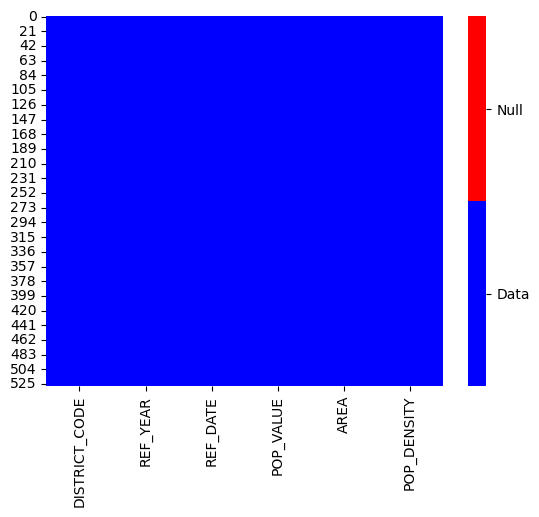

In [207]:
#Heatmap to show all data is there
colours = ['blue','red'] 
ax = sns.heatmap(data=bev_dichte.isnull(),cmap=sns.color_palette(colours), vmin=0, vmax=1)
colorbar = ax.collections[0].colorbar

colorbar.set_ticks([0.25,0.75])
colorbar.set_ticklabels(['Data', 'Null'])

In [208]:
#Check if all districts are represented
print(bev_dichte['DISTRICT_CODE'].unique())
#Check if all years have 24 rows (so 1 value for each district + 1 row for whole of Vienna)
bev_dichte.groupby(by=['REF_YEAR']).size()

[90000 90100 90200 90300 90400 90500 90600 90700 90800 90900 91000 91100
 91200 91300 91400 91500 91600 91700 91800 91900 92000 92100 92200 92300]


REF_YEAR
2002    24
2003    24
2004    24
2005    24
2006    24
2007    24
2008    24
2009    24
2010    24
2011    24
2012    24
2013    24
2014    24
2015    24
2016    24
2017    24
2018    24
2019    24
2020    24
2021    24
2022    24
2023    24
dtype: int64

In [209]:
#Check for duplicates (no duplicate rows with same year and same district code)
bev_dichte.duplicated(subset=['DISTRICT_CODE', 'REF_YEAR']).any()

False

#### Analyse the Data

Now that we have the population density data for each district we can merge it with the dog data and compare it

In [210]:
#Merge population values and dog data, so we can analyse it
df_h4_dogs_pop = dogs_2002.merge(bev_dichte, how='inner', left_on=['DISTRICT_CODE','REF_YEAR'], right_on=['DISTRICT_CODE','REF_YEAR'], suffixes=('_dogs', '_population'))
df_h4_dogs_pop.head(10)

,NUTS,DISTRICT_CODE,REF_YEAR,REF_DATE_dogs,DOG_VALUE,DOG_DENSITY,Postal_CODE,REF_DATE_population,POP_VALUE,AREA,POP_DENSITY
0,AT13,90000,2002,2002-01-01,46933,29.87,1000,2002-01-01,1571123,414.87,3787.02
1,AT13,90100,2002,2002-01-01,542,30.74,1010,2002-01-01,17630,2.87,6145.48
2,AT13,90200,2002,2002-01-01,2251,25.29,1020,2002-01-01,89016,19.24,4626.13
3,AT13,90300,2002,2002-01-01,1904,23.16,1030,2002-01-01,82227,7.40,11115.15
4,AT13,90400,2002,2002-01-01,615,21.23,1040,2002-01-01,28975,1.78,16322.03
5,AT13,90500,2002,2002-01-01,862,17.31,1050,2002-01-01,49785,2.01,24748.48
6,AT13,90600,2002,2002-01-01,604,21.17,1060,2002-01-01,28525,1.46,19604.22
7,AT13,90700,2002,2002-01-01,532,18.40,1070,2002-01-01,28912,1.61,17977.33
8,AT13,90800,2002,2002-01-01,474,21.33,1080,2002-01-01,22219,1.09,20385.42
9,AT13,90900,2002,2002-01-01,865,22.59,1090,2002-01-01,38290,2.97,12903.62


In [211]:
#Check if all districts are still there
print(df_h4_dogs_pop['DISTRICT_CODE'].unique())
#Check if all years have 24 rows (so 1 value for each district + 1 row for whole of Vienna)
print(df_h4_dogs_pop.groupby(by=['REF_YEAR']).size())

[90000 90100 90200 90300 90400 90500 90600 90700 90800 90900 91000 91100
 91200 91300 91400 91500 91600 91700 91800 91900 92000 92100 92200 92300]
REF_YEAR
2002    24
2003    24
2004    24
2005    24
2006    24
2007    24
2008    24
2009    24
2010    24
2011    24
2012    24
2013    24
2014    24
2015    24
2016    24
2017    24
2018    24
2019    24
2020    24
2021    24
2022    24
2023    24
dtype: int64


In [212]:
#Check for missing values in merged dataframe
print(((df_h4_dogs_pop.isnull().sum() / len(df_h4_dogs_pop)) * 100).sort_values(ascending=False))

NUTS                   0.0
DISTRICT_CODE          0.0
REF_YEAR               0.0
REF_DATE_dogs          0.0
DOG_VALUE              0.0
DOG_DENSITY            0.0
Postal_CODE            0.0
REF_DATE_population    0.0
POP_VALUE              0.0
AREA                   0.0
POP_DENSITY            0.0
dtype: float64


Now that the data is merged we can analyse it

In [213]:
#Firstly, lets look at the number of dogs in districts over the years
fig = px.line(dogs_2002[dogs_2002['DISTRICT_CODE']!=90000], x='REF_YEAR', y='DOG_VALUE',
              color='Postal_CODE', markers=True,
              width=800, height=500,
                 labels={
                     "DOG_VALUE": "Number of Dogs",
                     "REF_YEAR": "Year",
                     "Postal_CODE": "Postal Code"
                  },
              title='Number of Dogs in each District from 2002 to 2023')
fig.show()

In [214]:
#Plot the population density for each district
#Need to exclude rows that show data for whole of Vienna
df_h4_dogs_pop_dist = df_h4_dogs_pop[df_h4_dogs_pop['DISTRICT_CODE']!=90000]

fig = px.scatter(df_h4_dogs_pop_dist, x='Postal_CODE', y='POP_DENSITY',
              color='Postal_CODE',
              hover_data='REF_YEAR',
              width=800, height=650,
                 labels={
                     "POP_DENSITY": "Density of Population (Population per km^2)",
                     "Postal_CODE": "Postal Code",
                     "REF_YEAR": "Year"
                  },
              title='Population Density in each District from 2002 to 2023')
fig.show()

To find out if there is a correlation between the number of dogs and the population density we can plot the number of dogs in each district and the population density for those districts against each other

In [230]:
#Show the number of dogs vs the population density for the most recent year (2023)
#Only data from 2023
df_h4_dogs_pop_2023 = df_h4_dogs_pop_dist[df_h4_dogs_pop_dist['REF_YEAR']==2023]

#Only show data for most recent year to make it clearer
fig = px.scatter(df_h4_dogs_pop_dist[df_h4_dogs_pop_dist['REF_YEAR']==2023], 
                y='DOG_VALUE', x='POP_DENSITY',
                hover_data='Postal_CODE',
                 color='Postal_CODE',
                 text='Postal_CODE',
                 width=900, height=700,
                 labels={
                     "DOG_VALUE": "Number of Dogs",
                     "POP_DENSITY": "Density of Population",
                     "Postal_CODE": "Postal Code"
                 },
              title='Density of Population vs Number of Dogs in Vienna by District in 2023')
fig.update_traces(marker=dict(size=10), showlegend=False)
fig.update_traces(textposition='top center')
#fig.update_traces(textposition=label_pos)
fig.show()

You can already tell that there is a negative correlation between the number of dogs and the population density in this plot, but let's plot a trendline over the data to make it more visible.

In [232]:
#Add trendline
coeffs = np.polyfit(df_h4_dogs_pop_2023['POP_DENSITY'], df_h4_dogs_pop_2023['DOG_VALUE'], 1)
vals = np.polyval(coeffs, df_h4_dogs_pop_2023['POP_DENSITY'])
    
line = px.line(x=df_h4_dogs_pop_2023['POP_DENSITY'], y=vals)

fig.add_trace(line.data[0])

fig.update_layout(font=dict(
        #family="Arial, monospace",
        size=16,
        color="black"
    ),showlegend=False
    )

fig.write_image("h4-plot.png", engine="orca") 

The trendline shows there is a negative correlation.
Let's also calculate the pearson correlation coefficient:

In [ ]:
df_h4_dogs_pop_dist['POP_DENSITY'].corr(df_h4_dogs_pop_dist['DOG_VALUE'], method='pearson')

The Pearson correlation coefficient indicates a negative correlation between the data, if the value is negative. Between 0 and –0.3 there is a weak negative correlation, between –0.3 and –0.5 there is a moderate negative correlation and if the value is less than –0.5 there is a strong negative correlation. 

The Pearson correlation coefficient we calculated is -0.61, which means that there is a moderate to strong correlation between the population density and the number of dogs.

### E3-H5: "The number of dogs in a Viennese district correlates positively with the number of dog waste bag dispensers that district."

Rationale: With the increasing number of dogs in Vienna, it needs to be assured that dog waste does not become an environmental or a public health issue. For this reason, it is desirable to have more dog poo bag dispensers in districts with a higher dog population. Therefore, the distribution of dog poo bag dispensers in each district is a crucial part in achieving an effective dog waste disposal. However, it remains unclear if this correlation between the dog population and number of dispensers exists or how it looks like. Understanding this relationship can help identify districts which are either underserved or overserved in terms of dog waste bag dispensers. Such insight can be taken into account for future city planning.

Datasets needed: vie-bez-biz-spo-dog-2002f.csv, HUNDESACKERLOGD.json, BEZIRKSGRENZEOGD.json

Further considerations: The data for the dog waste bag dispenser is up-to-date (file downloaded on 2024-10-10) for the dog data only the most recent data is considered, which is 2023. It is assumed that there is a negligible fluctuation in number and location of dispensers since 2023. Additionally, dogs and their owners are not restricted to their home district for their walks and the need for a dog poo bag dispenser.

Author: Anna Till


#### Obtain and scrub additional dataset
Dataset: Hundekotsackerlspender Standorte Wien (Dog poo bag dispensers)
File name: HUNDESACKERLOGD.json 
Source: https://www.data.gv.at/katalog/dataset/98908792-f315-4834-9b5e-20fed66cbe5a
Description: Location of each dog poo bag dispenser in Vienna up-to-date.

BEZ: Bezirk
STRNAM: Straßenname
ONRTEXT: Ordnungsnummer oder zusätzliche Lagebeschreibung
BEMERKUNG: weitere Informationen
ID_NR: Identifikationsnummer des Standortes

In [ ]:
import geopandas as gpd

dog_poo_bag_dispensers= gpd.read_file('HUNDESACKERLOGD.json') # load dog waste bag dispenser data

# Preview and info
print(dog_poo_bag_dispensers.info())
print(dog_poo_bag_dispensers.head())

# Missing values
print("Missing values: ",dog_poo_bag_dispensers.isnull().sum())
# missing data is irrelevant except for the district ('Bezirk') which is needed for each dispenser, which is zero

# Delete duplicates
dog_poo_bag_dispensers = dog_poo_bag_dispensers.drop_duplicates()

# Check geography (and delete if invalid)
print("Valid geography: ", dog_poo_bag_dispensers.geometry.is_valid.all())
dog_poo_bag_dispensers = dog_poo_bag_dispensers[dog_poo_bag_dispensers.geometry.is_valid]

# Check coordinate system
print("Coordindate system: ", dog_poo_bag_dispensers.crs)

#### Results:

In [ ]:
from scipy.stats import pearsonr

# Data for dog poo bag dispenser
dispensers_by_district = dog_poo_bag_dispensers.groupby('BEZIRK').size().reset_index(name='NUMBER_DISPENSER')  # count number of dispenser per district

# Dog data
dogs = dogs_2002.copy()
dogs['DISTRICT_CODE'] = dogs['DISTRICT_CODE'].astype(str)

# Filter for the latest year
latest_year = dogs['REF_YEAR'].max()
dogs_year = dogs[dogs['REF_YEAR'] == latest_year]

dogs_year = dogs_year.assign(BEZIRK=dogs_year['DISTRICT_CODE'].str[1:3].astype(int)) # district code has form 9BBZZ, we want only BB in order to merge

# Aggregate for each district
dogs_year = dogs_year.groupby('BEZIRK', as_index=False)[['DOG_VALUE', 'DOG_DENSITY']].sum()

# Merge data for dogs with data for dispensers
merged_data = pd.merge(dogs_year, dispensers_by_district, left_on='BEZIRK', right_on='BEZIRK', how='left')
merged_data['NUMBER_DISPENSER'] = merged_data['NUMBER_DISPENSER'].fillna(0)

# Calculation correlation and rations
correlation, _ = pearsonr(merged_data['DOG_DENSITY'], merged_data['NUMBER_DISPENSER'])
print(f'Pearson correlation: {correlation:.2f}')
# Ratios
merged_data['DOGS_TO_DISPENSER'] = merged_data['DOG_VALUE'] / merged_data['NUMBER_DISPENSER']
merged_data['DOGS_DENS_TO_DISPENSER'] = (merged_data['DOG_DENSITY'] / merged_data['NUMBER_DISPENSER'])*100

# District borders for graphical presentation
district_borders = gpd.read_file('BEZIRKSGRENZEOGD.json')
district_borders = district_borders.to_crs(epsg=4326)  # transform coordinates

# Merge district borders with dog and dispenser data
merged_data = district_borders.merge(merged_data, left_on='BEZNR', right_on='BEZIRK', how='left')

# Scatter plot for correlation
plt.figure(figsize=(10, 6))
plt.scatter(merged_data['DOG_DENSITY'], merged_data['NUMBER_DISPENSER'], color='blue')
sns.regplot(x='DOG_DENSITY', y='NUMBER_DISPENSER', data=merged_data, scatter=False, ax=plt.gca(), color='red') # adds fit to plot
plt.xlabel('Dog Density (Dogs per 1000 People)')
plt.ylabel('Number of Dog Poo Bag Dispensers')
plt.title(f'Correlation between Dog Density and Number of Dog Poo Bag Dispensers ({latest_year})')
plt.grid()
plt.show()

# Maps with analysis of correlation in each district
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
merged_data.boundary.plot(ax=ax1, color='black')  # plot district borders
merged_data.boundary.plot(ax=ax2, color='black')    
fig.suptitle(f'Analysis of Dogs and Poo Bag Dispensers in Viennese Districts for {latest_year}', fontsize=16)

# First map: absloute number of dogs
merged_data.plot(column='DOGS_TO_DISPENSER', ax=ax1, legend=True, cmap='viridis', edgecolor='black', alpha=0.5, legend_kwds={'orientation': "horizontal", 'label': "number of dogs / number of dispensers", 'shrink': 0.8})
ax1.set_title('Ratio: Number of dogs to number of poo bag dispensers')
ax1.set_xlabel('Longitude [degrees]')
ax1.set_ylabel('Latitude [degrees]')

for idx, row in merged_data.iterrows():  # ratio in each district in plot
    point = row.geometry.representative_point() 
    ax1.text(point.x, point.y, f'{int(round(row["DOGS_TO_DISPENSER"]))}', fontsize=10, ha='center', va='center', color='black')

# Second map: dog density per 1000 pop
merged_data.plot(column='DOGS_DENS_TO_DISPENSER', ax=ax2, legend=True, cmap='viridis', edgecolor='black', alpha=0.5,
                 legend_kwds={'orientation': "horizontal", 'label': "dog density / number of dispensers", 'shrink': 0.8})
ax2.set_title('Ratio: Dog density to number of poo bag dispensers')
ax2.set_xlabel('Longitude [degrees]')
ax2.set_ylabel('Latitude [degrees]')
for idx, row in merged_data.iterrows():
    point = row.geometry.representative_point() 
    ax2.text(point.x, point.y, f'{row["DOGS_DENS_TO_DISPENSER"]:.2f}', fontsize=10, ha='center', va='center', color='black')

plt.tight_layout()
plt.show()

# categorization
# low, medium, high
def categorize(value):
    if value <= merged_data['DOGS_DENS_TO_DISPENSER'].quantile(1/3):
        return 'Low'
    elif value <= merged_data['DOGS_DENS_TO_DISPENSER'].quantile(2/3):
        return 'Medium'
    else:
        return 'High'

merged_data['CATEGORY_DOG_TO_BAG'] = merged_data['DOGS_DENS_TO_DISPENSER'].apply(categorize)

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
merged_data.boundary.plot(ax=ax, color='black')
merged_data.plot(column='CATEGORY_DOG_TO_BAG', ax=ax, legend=True, cmap='Set1', edgecolor='black', alpha=0.5)
ax.set_title(f'Categorization: Dog Density per 1000 people to Dog Poo Bag Dispenser ({latest_year})')
ax.set_xlabel('Longitude [degrees]')
ax.set_ylabel('Latitude [degrees]')
for idx, row in merged_data.iterrows():
    point = row.geometry.representative_point()
    ax.text(point.x, point.y, row['BEZ_RZ'], fontsize=10, ha='center', va='center', color='black')

plt.tight_layout()
plt.show()

#### Answer:
The Pearson correlation coefficient of 0.70 indicates a positive correlation between the number of dogs and of dispensers in a district. Which means, that indeed in districts with a higher dog population also a higher number of dog poo bag dispensers is installed. However, in the scatter plot ("Correlation between Dog Density and Number of Dog Poo Bag Dispensers (2023)") it can be seen that there are some outliers despite the correlation depicted by the trend line.

Another aspect is the comparison ("Analysis of Dogs and Poo Bag Dispensers in Viennese Districts for 2023") between the ratios of the number of dogs per dog waste bag dispenser in each district and of the density of dogs per dispenser, which takes also population density into account. The direct comparison between the absolute numbers - dogs per dispenser - suggests that a higher ratio may need a more frequent refill, assuming one waste bag per dog poo. As displayed in the results ("Ratio: Number of dogs to number of poo bag dispensers") this is the case especially in the outer districts of Vienna. Whereas, the broader context of the dog density per dog waste bag dispenser, normalizing the number of dogs against the population, implies whether there are enough dispensers available for each resident (regardless if or how many dogs they own). In this case, the results ("Ratio: Dog density to number of poo bag dispensers") show a different picture than for the direct ratio. Here, the inner districts of Vienna are affected the most by having the higher dog density to dispenser ratio. For instance, the first district, "Innere Stadt", has a rather low number of dogs per dispenser. However, value of the dog density to dispensers is exceedingly high compared to other districts. 

Finally, the map "Categorization: Dog Density per 1000 people to Dog Poo Bag Dispenser (2023)" provides a further investigation of dog density per dispenser by categorizing the districts into "high", "medium" and "low" based on tertiles. It can be seen at glance that the innermost districts might profit most from additional dog waste bag dispensers with respect to each resident.

In summary, there is a correlation between the dog population and the number of dog waste bag dispensers. The number of dogs per dispenser is larger in the outer districts of Vienna, whereas when also taking the population per district into account, the picture reverses.

### E3-H6: "xxx"
Author: Group member 6
